<a href="https://colab.research.google.com/github/uervitonsantos/Otimizacao-Politicaca-Manutencao-Preventiva-Imperfeita/blob/main/Algoritmo_PSO_para_otimiza%C3%A7%C3%A3o_de_custo_de_manuten%C3%A7%C3%A3o_preventiva_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset de dados de confiabilidade: https://drive.google.com/drive/folders/1b7jqK1A2XI1oZ4YhDXw_4xdnSTbfuBVK?usp=sharing

In [52]:
%%capture
pip install pyswarms

In [53]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import time
from pyswarms.single.global_best import GlobalBestPSO
import pyswarms as ps
from pyswarms.utils.search import RandomSearch
from pyswarms.utils.functions import single_obj as fx
from pyswarms.utils.plotters import (plot_cost_history, plot_contour, plot_surface)
import plotly.graph_objects as go
from pyswarms.utils.plotters.formatters import Designer
from pyswarms.utils.plotters.formatters import Mesher
from mpl_toolkits.mplot3d import Axes3D

In [54]:
MAX_VALUE_CUSTO = 100
fator_melhoria = 'expo'

In [55]:
# Custos MC e MP
CMC = 4000
CMP = 2000

In [56]:
class IntensidadeFalha:
    # Este método vai inicializar cada objeto criado a partir desta classe
    # O nome deste método é "inicio"
    # (self) é uma referência a cada atributo de um objeto criado a partir desta classe
    # Os atributos de cada objeto criados a partir desta classe.
    # O self indica que estes são atributos dos objetos
    def __init__(self):
        self.fator = None
        self.lamb = None
        self.beta = None
        self.theta = None
        self.sz = None
        self.T = None
        self.u = None

    def inicio(self, T, fator, solucao):
        self.fator = fator
        self.lamb = solucao[0]
        self.beta = solucao[1]
        self.theta = solucao[2]
        self.sz = int(T[-1])
        self.T = T

    def create(self):
        self.u = []
        # Reducao de Idade com fator de melhoria linear
        for i, tc in enumerate(self.T[1:], start=1):
            for tt in range(int(self.T[i-1]), int(tc)+1):
                b = tt - self.fator[0][i-1] * self.T[i-1]
                self.u.append((1 / (self.lamb ** self.beta)) * self.beta * b ** (self.beta - 1))

                if tt == tc:
                    self.u.append(float('nan'))
            break
    # plota e salva a figura da função de intensidade de falha
    def plotar(self):
        fig = plt.figure(figsize=(20, 5))
        plt.plot(self.u)

        for xc in self.T:
            plt.axvline(x=xc, color='r', linestyle='--')

        plt.xlabel("Tempo (dias)")
        plt.ylabel("Função intensidade de falha")
        plt.xlim(0)
        plt.grid(True)
        plt.show()

In [57]:
# Define a função de melhoria constante
def const(ck, m, s, theta):
    fator = [[theta] * ck] * m
    return fator

In [58]:
# Define a função de melhoria linear
def linear(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = [0]
        for j in range(0, ck, 1):
            linha.append(s[k][j] * theta)
        fator.append(linha)
    return fator

In [59]:
 # Define a função de melhoria exponencial
def expo(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(1.0 - np.exp(-s[k][j] * theta))
        fator.append(linha)
    return fator

In [60]:
# Define a função de melhoria potência
def pot(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(s[k][j] ** theta)
        fator.append(linha)
    return fator

In [61]:
# Define a função de melhoria para manutenção perfeita
def mpp(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(1)
        fator.append(linha)
    return fator

In [62]:
# Executa a função de melhoria com base no parâmetro fornecido
def execute_function(fator_melhoria, ck, m, s, theta):
    return {
        'const': lambda: const(ck, m, s, theta),
        'linear': lambda: linear(ck, m, s, theta),
        'expo': lambda: expo(ck, m, s, theta),
        'pot': lambda: pot(ck, m, s, theta),
        'mpp': lambda: mpp(ck, m, s, theta),
    }[fator_melhoria]()

In [63]:
# Função custo de manutenção baseada em severidade
def custo_mp(s, CMP):
    dist = {0.25: 2000, 0.5: 4000, 0.75: 12000, 1.0: 20000}
    if not isinstance(s, list):
        s = [s]  # Transforma s em uma lista com um único elemento
    cmp_f = np.sum([CMP if si < 0.25 or si > 1.0 else np.interp(si, [0.25, 0.5, 0.75, 1.0], [2000, 4000, 12000, 20000]) for si in s])
    return cmp_f

In [64]:
# Leitura dos dados de tempo: exemplo tese Marcos Coque Jr.
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DateSet/data.csv', sep=";")
df.head()

,t,k,c,n,s,T
0,90,1,1,4.0,0.4,0.0
1,110,1,1,0.0,0.5,150.0
2,125,1,1,9.0,0.9,250.0
3,135,1,1,2.0,0.2,500.0
4,295,1,3,2.0,0.4,600.0


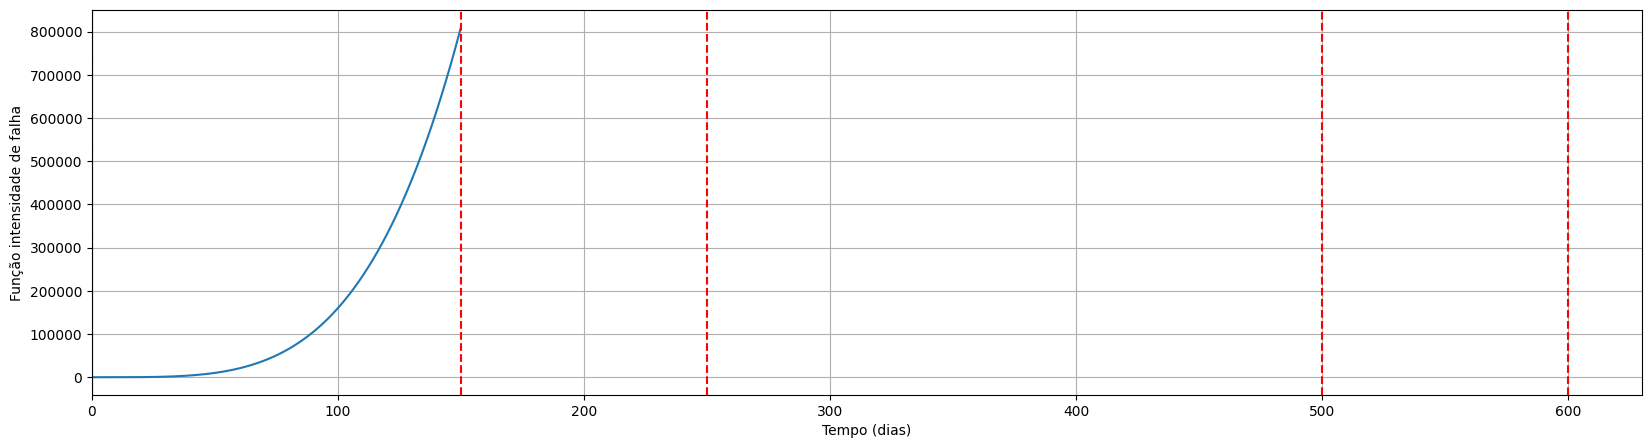

Fator ajuste:  [0.5506710358827784, 0.6321205588285577, 0.8347011117784134, 0.3296799539643607]


In [70]:
# Cria as variaveis
# tempos de falhas
t = df['t']
# indice do sistema
k = df['k']
m = k.drop_duplicates().shape[0]
# Numero de ciclos de manutenção
ck = df['c'].max()
# Numero de falhas e severidade das manutenções preventivas em cada sistema
n = []
s = []
for k in range(m):
    n.append(list(df['n'][k * ck:(k + 1) * ck]))
    s.append(list(df['s'][k * ck:(k + 1) * ck]))

# Tempos das MP
T = list(df['T'][:m])

# Criação de variáveis para os parâmetros
lamb = 5
theta = 2

# Cria alguns cenários de teste
beta = 5

solucao = [lamb, beta, theta]

# Cria a instância da classe IntensidadeFalha
intensidadeFalha = IntensidadeFalha()

# Inicializa a instância com os valores necessários
falha = intensidadeFalha.inicio(T, execute_function(fator_melhoria, ck, m, s, theta), solucao)

# Cria os dados da intensidade de falha
intensidadeFalha.create()

# Plota o gráfico da intensidade de falha
intensidadeFalha.plotar()

fator = execute_function(fator_melhoria, ck, m, s, theta)
print('Fator ajuste: ', fator[0])

last_value_fator_ajuste = fator[0][-1]

time_duration = 1
time.sleep(time_duration)

In [71]:
def objective_st(x):

    # Dicionario para severidades
    dict_severidades = {1:0.25, 3:0.50, 5:0.75, 7:1.0}

    # Criação de variáveis para os parâmetros
    lamb = x[0]
    beta = x[1]
    theta = x[2]

    # Cálculo da intensidade de falha
    # Cria as variaveis
    # tempos de falhas
    t = df['t']
    # indice do sistema
    k = df['k']
    m = df['k'].nunique()
    # Numero de ciclos de manutenção
    ck = df['c'].max()
    # Numero de falhas e severidade das manutenções preventivas em cada sistema
    n = []
    s = []

    # Obter o número de ciclos de manutenção
    num_ciclos = ck

    for k in range(m):
        n.append(list(df['n'][k * ck:(k + 1) * ck]))
        s_row = []  # Criar uma nova lista para cada sistema
        for j in range(num_ciclos):
            s_row.append(df['s'][k * ck + j])  # Usar a variável 'j' para obter a severidade correta
        s.append(s_row)

    # Tempos das MP
    T = list(df['T'][:m])

    # Obter os tempos para manutenções preventivas
    tempos_mp = T[1:]

    # Cria alguns cenários de teste
    beta = 5

    fact = execute_function(fator_melhoria, ck, m, s, theta)
    fator = [last_value_fator_ajuste] + list(fact[0])

    termos_somatorio = [((1 / (lamb ** beta)) * (T[1] ** beta))]
    numero_medio_falhas = [0, ((1 / (lamb ** beta)) * (T[1] ** beta))]

    for i in range(ck - 1):
        termo = (((T[i + 2] - fator[i] * T[i + 1]) ** beta) - (((1 - fator[i]) * T[i + 1]) ** beta)) * (1 / (lamb ** beta))
        termos_somatorio.append(termo)
        numero_medio_falhas.append(sum(termos_somatorio))

    final = 730
    termo = (((final - fator[ck - 1] * T[ck]) ** beta) - (((1 - fator[ck - 1]) * T[ck]) ** beta)) * (1 / (lamb ** beta))
    termos_somatorio.append(termo)
    numero_medio_falhas.append(sum(termos_somatorio))

    mi = numero_medio_falhas

    Ctotal = []
    for i in range(ck):
        cmp = custo_mp(s[0][i], CMP)
        Ctotal.append((cmp + (mi[i + 1] - mi[i]) * CMC) / (T[i + 1] - T[i]))

    cmp = custo_mp(s[0][ck - 1], CMP)
    Ctotal.append((cmp + (mi[ck + 1] - mi[ck]) * CMC) / (final - T[ck]))

    Custo = np.sum(np.minimum(Ctotal, MAX_VALUE_CUSTO))

    print("")
    print("=========================================================================")
    print("")

    print('Media de falhas:', mi)

    print('Fator:', fator)

     # Imprimir o custo total para manutenções preventivas
    print("Custo Total:", Custo)

     # Imprimir o número de ciclos de manutenção
    print("Número de Ciclos de Manutenção:", num_ciclos)

    # Imprimir os tempos para manutenções preventivas
    print("Tempos para Manutenções Preventivas:", tempos_mp)

    # Imprimir os tempos para manutenções preventivas
    print("Número de Sisemas:", m)

    # Imprimir a severidade para cada ciclo de manutenção
    print("=========================================================================")
    print("")
    for k in range(m):

        for i in range(num_ciclos):
            if not np.isnan(s[k][i]):
                print("Severidade para Ciclo de Manutenção", i+1, "do Sistema", k+1, ":", s[k][i])

    return Custo

In [72]:
num_particles = 100
max_iterations = 100
dimensions = 3
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}

optimizer = GlobalBestPSO(n_particles=num_particles, dimensions=dimensions, options=options)

# Inicializar current_cost e pbest_cost com valores infinitos
optimizer.swarm.current_cost = np.full(optimizer.swarm.position.shape[0], np.inf)
optimizer.swarm.pbest_cost = np.full(optimizer.swarm.position.shape[0], np.inf)
best_cost, best_position = optimizer.optimize(objective_st, iters=max_iterations)

pbest_cost = optimizer.swarm.pbest_cost

best_positions = []  # Lista para armazenar todas as melhores posições

# Lista para armazenar o custo em cada iteração
cost_history = []

# Loop de iterações do PSO
for i in range(max_iterations):
    best_cost, best_position = optimizer.optimize(objective_st, iters=1)
    pbest_cost = optimizer.swarm.pbest_cost
    best_positions.append(best_position)
    cost_history.append(best_cost)

# Converter a lista de melhores posições em um array numpy para facilitar a manipulação
best_positions = np.array(best_positions)

2023-07-06 00:25:05,085 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   1%|          |1/100, best_cost=1500.0



Media de falhas: [0, array([2.09675471e+11, 2.85629400e+11, 3.05305241e+13]), array([1.07704128e+12, 1.46719429e+12, 1.56826331e+14]), array([5.29578845e+13, 1.14008573e+14, 1.01332750e+16]), array([1.04200303e+14, 2.85163389e+14, 2.29782042e+16]), array([1.75500998e+14, 7.53785550e+14, 4.97320951e+16])]
Fator: [0.3296799539643607, array([0.18685146, 0.00484366, 0.08036114]), array([0.22783101, 0.00605091, 0.09942136]), array([0.37211192, 0.01086526, 0.17179289]), array([0.09825251, 0.00242477, 0.04102197])]
Custo Total: 1500.0
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5


pyswarms.single.global_best:   5%|▌         |5/100, best_cost=1500.0



Media de falhas: [0, array([1.80447909e+10, 1.43932160e+10, 4.40312883e+11]), array([9.26907882e+10, 7.39337210e+10, 2.26175789e+12]), array([2.96567038e+12, 1.33721206e+12, 8.79353691e+13]), array([4.73828305e+12, 1.70267634e+12, 1.53958450e+14]), array([6.08000033e+12, 1.84866672e+12, 2.19396234e+14])]
Fator: [0.3296799539643607, array([0.34268902, 0.530706  , 0.27368076]), array([0.40814733, 0.61157582, 0.32948356]), array([0.61096874, 0.81771486, 0.51299101]), array([0.18925282, 0.31494964, 0.14775635])]
Custo Total: 1500.0
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5


pyswarms.single.global_best:   9%|▉         |9/100, best_cost=-8.7e+24

 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


Media de falhas: [0, array([ 3.03149466e+14,  8.86271194e+12, -2.86553162e+13]), array([ 1.55718973e+15,  4.55251469e+13, -1.47193939e+14]), array([ 1.12236135e+17,  1.26739752e+16, -1.69625581e+16]), array([ 2.69689848e+17,  6.22086028e+16, -5.24239278e+16]), array([ 6.55341568e+17,  9.02345732e+17, -2.

pyswarms.single.global_best:  11%|█         |11/100, best_cost=-8.7e+24



Media de falhas: [0, array([-2.11128374e+13,  6.36828706e+13, -2.76729563e+12]), array([-1.08450441e+14,  3.27120193e+14, -1.42147845e+13]), array([-8.54134659e+15,  9.12519778e+16, -2.16846398e+15]), array([-2.15183163e+16,  4.48355795e+17, -7.78503270e+15]), array([-5.77643125e+16,  6.52170216e+18, -4.89028501e+16])]
Fator: [0.3296799539643607, array([-0.00078507, -0.61364519, -0.29906902]), array([-0.00098144, -0.81869578, -0.38688447]), array([-1.76728318e-03, -1.93472969e+00, -8.01658647e-01]), array([-0.00039246, -0.27029335, -0.13976709])]
Custo Total: -3.2981491014776453e+18
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
S

pyswarms.single.global_best:  16%|█▌        |16/100, best_cost=-8.7e+24

: 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


Media de falhas: [0, array([ 5.72127337e+13,  7.98263174e+12, -3.45262235e+13]), array([ 2.93885001e+14,  4.10044335e+13, -1.77351064e+14]), array([ 2.17331865e+16,  4.46815069e+15, -1.91946450e+16]), array([ 5.29417665e+16,  1.34003134e+16, -5.73564079e+16]), array([ 1.32347502e+17,  5.36230203e+16, -2.27507721e+17])]
Fator: [0.3296799539643607, array([ 0.02540982, -0.14175269, -0.13869724]), array([ 0.03166075, -0.18022566, -0.17627897]), array([ 0.05626608, -0.34752582, -

pyswarms.single.global_best:  20%|██        |20/100, best_cost=-8.7e+24

 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de

pyswarms.single.global_best:  24%|██▍       |24/100, best_cost=-8.7e+24

 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


Media de falhas: [0, array([-6.93714899e+14,  4.02976879e+13, -6.12634260e+12]), array([-3.56340959e+15,  2.06997381e+14, -3.14692217e+13]), array([-2.73819601e+17,  2.95294616e+16, -4.01915163e+15]), array([-6.80813513e+17,  1.02300243e+17, -1.31250871e+16]), array([-1.77688290e+18,  5.86283578e+17, -6.47675444e+16])]
Fator: [0.3296799539643607, array([ 0.00950261, -0.26674916, -0.21449716]), array([ 0.01186412, -0.34388864, -0.27495727]), array([ 0.02125398, -0.70236981, -0.54843199]), array([ 0.00476265, -0.12549952, -0.10204227])]
Custo Total: -5.648057037796621e+19
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [

pyswarms.single.global_best:  26%|██▌       |26/100, best_cost=-8.7e+24

1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


Media de falhas: [0, array([ 2.64496687e+15,  1.04126764e+13, -1.54367454e+13]

pyswarms.single.global_best:  31%|███       |31/100, best_cost=-8.7e+24


Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


Media de falhas: [0, array([ 7.81547414e+18,  2.80974174e+13, -8.74448625e+12]), array([ 4.01457941e+19,  1.44328177e+14, -4.49178563e+13]), array([ 3.17062783e+21,  1.33679716e+16, -5.98117790e+15]), array([ 7.99971648e+21,  3.67380997e+16, -1.99730017e+16]), array([ 2.15435971e+22,  1.19667270e+17, -1.04250698e+17])]
Fator: [0.3296799539643607, array([-0.00195253, -0.06992035, -0.23405012]), array([-0.00244126, -0.08815136, -0.30066663]), array([-0.00439856, -0.16423527, -0.6050878 ]), array([-0.00097579, -0.03436954, -0.11087808])]
Custo Total: -3.24949312167783e+18
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade par

pyswarms.single.global_best:  33%|███▎      |33/100, best_cost=-8.7e+24

0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


Media de falhas: [0, array([-1.21613287e+17,  1.89125822e+13, -1.02143518e+13]), array([-6.24691721e+17,  9.71483775e+13, -5.24681239e+13]), array([-4.58012775e+19,  2.44383793e+16, -6.10615014e+15]), array([-1.11061129e+20,  1.13914783e+17, -1.89713140

pyswarms.single.global_best:  37%|███▋      |37/100, best_cost=-2.65e+26



Media de falhas: [0, array([ 2.09223711e+17,  1.55021056e+13, -1.23766099e+13]), array([ 1.07472072e+18,  7.96297609e+13, -6.35750081e+13]), array([ 8.02778579e+19,  1.36964755e+16, -7.86216367e+15]), array([ 1.96604335e+20,  5.23953181e+16, -2.52358474e+16]), array([ 4.97010704e+20,  3.88418526e+17, -1.19278822e+17])]
Fator: [0.3296799539643607, array([ 0.02126341, -0.35816913, -0.19952324]), array([ 0.02650824, -0.46619697, -0.25533845]), array([ 0.047208  , -0.99134347, -0.50580765]), array([ 0.01068883, -0.16540514, -0.09522748])]
Custo Total: -3.7157327458384307e+18
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade pa

pyswarms.single.global_best:  41%|████      |41/100, best_cost=-2.65e+26

3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


Media de falhas: [0, array([-2.61028539e+17,  3.47790396e+13, -8.75803094e+12]), array([-1.34082690e+18,  1.78649707e+14, -4.49874313e+13]), array([-1.03046212e+20,  1.20810084e+16, -5.50936969e+15]), array([-2.56228836e+20,  2.80624959e+16, -1.75915206e+16]), array([-6.68847890e+20,  6.36743382e+16, -8.20719464e+16])]
Fator: [0.3296799539643607, array([ 0.00944455,  0.06200541, -0.19500216]), array([ 0.01179172,  0.07689645, -0.24942694]), array([ 0.0211249 ,

pyswarms.single.global_best:  43%|████▎     |43/100, best_cost=-1.47e+28

 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidad

pyswarms.single.global_best:  49%|████▉     |49/100, best_cost=-1.47e+28

4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


Media de falhas: [0, array([ 1.23505601e+21,  2.37845840e+13, -1.03139939e+13]), array([ 6.34411977e+21,  1.22174419e+14, -5.29799557e+13]), array([ 4.98877180e+23,  7.18586212e+15, -6.26068848e+15]), array([ 1.25578626e+24,  1.55092936e+16, -1.96116209e+16]), array([ 3.36506841e+24,  3.05909230e+16, -8.72672174e+16])]
Fator: [0.3296799539643607, array([-1.36382820e-04,  1.17710798e-01, -1.78578115e-01]), array([-1.70481431e-04,  1.44906303e-01, -2.27998865e-01]), array([-3.06887502e-04,  2.45560065e-01, -4.47292587e-01]), array([-6.81890851e-05,  6.06974918e-02, -8.56233761e-02])]
Custo Total: -2.7170529725711447e+18
Número de Ciclos de Ma

pyswarms.single.global_best:  51%|█████     |51/100, best_cost=-1.47e+28

 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


Media de falhas: [0, array([-1.55207532e+20,  2.76499974e+13, -1.01870217e+13

pyswarms.single.global_best:  53%|█████▎    |53/100, best_cost=-1.47e+28

0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


Media de falhas: [0, array([ 3.51711131e+20,  2.26439240e+13, -1.08255084e+13]), array([ 1.80663673e+21,  1.16315184e+14, -5.56074555e+13]), array([ 1.42794950e+23,  6.97880576e+15, -6.92697683e+15]), array([ 3.60431184e+23,  1.52201486e+16, -2.23207875e+16]), array([ 9.71524606e+23,  3.05998005e+16, -1.06528081e+17])]
Fator: [0.3296799539643607, array([-0.00227756,  0.10986447, -0.20289001]), array([-0.00284776,  0.13539017, -0.25974429]), array([-0.00513181,  0.23038008, -0.51533381]), array([-0.00113813,  0.05653006, -0.09676342])]
Custo Total: -3.318767930572953e+18
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade

pyswarms.single.global_best:  57%|█████▋    |57/100, best_cost=-1.47e+28

 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


Media de falhas: [0, array([-5.90963843e+22,  2.64305817e+13, -9.85125431e+12]), array([-3.03560761e+23,  1.35766131e+14, -5.06029986e+13]), array([-2.36914951e+25,  8.08738850e+15, -5.81796880e+15]), array([-5.93967812e+25,  1.75714681e+16, -1.79584775e+16]), array([-1.57792171e+26,  3.5082

pyswarms.single.global_best:  62%|██████▏   |62/100, best_cost=-1.47e+28



Media de falhas: [0, array([-3.80748312e+20,  2.36266054e+13, -1.02123945e+13]), array([-1.95579219e+21,  1.21362929e+14, -5.24580696e+13]), array([-1.53882674e+23,  7.43329868e+15, -6.57424855e+15]), array([-3.87474144e+23,  1.63875536e+16, -2.12528233e+16]), array([-1.03896784e+24,  3.36157045e+16, -1.02252743e+17])]
Fator: [0.3296799539643607, array([-0.00037235,  0.10170652, -0.20569334]), array([-0.00046546,  0.12547383, -0.26341514]), array([-0.00083799,  0.21441884, -0.52329123]), array([-0.00018616,  0.05221654, -0.09804068])]
Custo Total: -3.1893606945443204e+25
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade pa

pyswarms.single.global_best:  66%|██████▌   |66/100, best_cost=-7e+28

 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


Media de falhas: [0, array([ 2.84774005e+22,  2.34564732e+13, -1.03575869e+13]), array([ 1.46280038e+23,  1.20489010e+14, -5.32038805e+13]), array([ 1.14958529e+25,  7.10295012e+15, -6.36321982e+15]), array([ 2.89281687e+25,  1.53486748e+16, -2.00617802e+16]), array([ 7.74628424e+25,  3.03401475e+16, -9.07019304e+16])]
Fator: [0.3296799539643607, array([ 1.20169425e-04,  1.16811582e-01, -1.84097766e-01]), array([ 1.50209524e-04,  1.43816792e-01, -2.35191949e-01]), array([

pyswarms.single.global_best:  68%|██████▊   |68/100, best_cost=-7e+28

 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade 

pyswarms.single.global_best:  74%|███████▍  |74/100, best_cost=-7e+28

: 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


Media de falhas: [0, array([ 5.33733099e+21,  2.44859439e+13, -1.03260487e+13]), array([ 2.74163009e+22,  1.25777099e+14, -5.30418780e+13]), array([ 2.16459713e+24,  7.39539262e+15, -6.19870264e+15]), array([ 5.46050888e+24,  1.59588558e+16, -1.93019808e+16]), array([ 1.47000576e+25,  3.14680640e+16, -8.46384159e+16])]
Fator: [0.3296799539643607, array([-0.00182034,  0.11783661, -0.17348867]), array([-0.00227594,  0.14505872, -0.22137388]), array([-0.00410043,  0.2458021 , -0.43326841]), array([-0.00090976,  0.06076447, -0.08327682])]
Custo Total: -2.6347975421265475e+18
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [

pyswarms.single.global_best:  76%|███████▌  |76/100, best_cost=-7e+28

 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


Media de falhas: [0, array([-3.67599679e+21,  2.43098263e+13, -1.01406610e+13])

pyswarms.single.global_best:  78%|███████▊  |78/100, best_cost=-1.86e+33

Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


Media de falhas: [0, array([-5.45805059e+22,  2.63850918e+13, -1.01609640e+13]), array([-2.80364020e+23,  1.35532463e+14, -5.21938863e+13]), array([-2.20150670e+25,  7.91539830e+15, -5.93355745e+15]), array([-5.53742765e+25,  1.70208911e+16, -1.82046876e+16]), array([-1.48138874e+26,  3.33478944e+16, -7.69836106e+16])]
Fator: [0.3296799539643607, array([ 0.00046561,  0.12048808, -0.16090968]), array([ 0.00058198,  0.14826958, -0.2050305 ]), array([ 0.00104732,  0.25089294, -0.39893156]), array([ 0.00023283,  0.06217703, -0.07745518])]
Custo Total: -4.546905764761655e+27
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade par

pyswarms.single.global_best:  85%|████████▌ |85/100, best_cost=-1.86e+33

 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


Media de falhas: [0, array([ 3.00998590e+22,  2.62477165e+13, -1.04310604e+13]), array([ 1.54614130e+23,  1.34826807e+14, -5.35812922e+13]), array([ 1.21582323e+25,  7.94227598e+15, -6.07396179e+15]), array([ 3.06049720e+25,  1.71556993e+16, -1.86069944e+16]), array([ 8.20104123e+25,  3.388812

pyswarms.single.global_best:  87%|████████▋ |87/100, best_cost=-1.86e+33



Media de falhas: [0, array([-1.32106952e+24,  2.63850807e+13, -1.01979887e+13]), array([-6.78594593e+24,  1.35532406e+14, -5.23840713e+13]), array([-5.32979506e+26,  7.92529090e+15, -5.96830425e+15]), array([-1.34076703e+27,  1.70532890e+16, -1.83329499e+16]), array([-3.58782979e+27,  3.34509406e+16, -7.77499750e+16])]
Fator: [0.3296799539643607, array([ 0.00036694,  0.11999737, -0.16191027]), array([ 0.00045865,  0.14767552, -0.20632892]), array([ 0.00082542,  0.24995221, -0.40164597]), array([ 0.00018349,  0.06191544, -0.07791942])]
Custo Total: -1.1012481417863312e+29
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade pa

pyswarms.single.global_best:  92%|█████████▏|92/100, best_cost=-1.86e+33

 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


Media de falhas: [0, array([ 3.41015742e+24,  2.63119828e+13, -1.02266096e+13]), array([ 1.75169766e+25,  1.35156924e+14, -5.25310883e+13]), array([ 1.37731771e+27,  7.95511364e+15, -5.96319159e+15]), array([ 3.46681710e+27,  1.71759713e+16, -1.82812940e+16]), array([ 9.28869669e+27,  3.39013257e+16, -7.71600909e+16])]
Fator: [0.3296799539643607, array([-9.07988618e-05,  1.17430508e-01, -1.60247390e-01]), array([-1.13499865e-04,  1.44566727e-01, -2.04171239e-01]), array([-2

pyswarms.single.global_best:  94%|█████████▍|94/100, best_cost=-1.86e+33

1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo d

pyswarms.single.global_best:  99%|█████████▉|99/100, best_cost=-1.86e+33


Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


Media de falhas: [0, array([-6.19003541e+23,  2.63559718e+13, -1.01950930e+13]), array([-3.17963929e+24,  1.35382883e+14, -5.23691970e+13]), array([-2.49963748e+26,  7.94504798e+15, -5.97375495e+15]), array([-6.29119690e+26,  1.71279298e+16, -1.83614861e+16]), array([-1.68527218e+27,  3.37121542e+16, -7.79932570e+16])]
Fator: [0.3296799539643607, array([-1.77169756e-05,  1.18585229e-01, -1.62454406e-01]), array([-2.21462686e-05,  1.45965519e-01, -2.07035130e-01]), array([-3.98636366e-05,  2.47241394e-01, -4.03123305e-01]), array([-8.85844859e-06,  6.11630756e-02, -7.81717888e-02])]
Custo Total: -5.173071519163449e+28
Número de Ciclos de Manutenção

pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-1.86e+33
2023-07-06 00:25:22,578 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.8588777041987488e+33, best pos: [-3.21017050e-04  3.10473898e-01 -3.74862585e-01]
2023-07-06 00:25:22,584 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-1.86e+33
2023-07-06 00:25:22,626 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.8588777041987488e+33, best pos: [ 0.00186258  0.3105463  -0.37465845]
2023-07-06 00:25:22,633 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([ 3.38748793e+24,  2.62920523e+13, -1.02867611e+13]), array([ 1.74005301e+25,  1.35054547e+14, -5.28400687e+13]), array([ 1.36723306e+27,  7.92334823e+15, -5.99352164e+15]), array([ 3.44018353e+27,  1.70784114e+16, -1.83664722e+16]), array([ 9.21015107e+27,  3.36048890e+16, -7.74393263e+16])]
Fator: [0.3296799539643607, array([ 0.00019349,  0.11870582, -0.15988801]), array([ 0.00024185,  0.14611158, -0.20370502]), array([ 0.00043529,  0.2474731 , -0.39616302]), array([ 9.67475498e-05,  6.12273027e-02, -7.69809686e-02])]
Custo Total: -2.4095716537730176e+18
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
S

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-1.86e+33
2023-07-06 00:25:22,661 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.8588777041987488e+33, best pos: [ 0.00243815  0.3105506  -0.37443495]
2023-07-06 00:25:22,663 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([ 8.81363798e+23,  2.62902339e+13, -1.03174983e+13]), array([ 4.52730684e+24,  1.35045206e+14, -5.29979571e+13]), array([ 3.55708895e+26,  7.90875695e+15, -5.99658489e+15]), array([ 8.94994295e+26,  1.70311660e+16, -1.83514812e+16]), array([ 2.39594245e+27,  3.34555112e+16, -7.71261080e+16])]
Fator: [0.3296799539643607, array([ 0.00021785,  0.11940305, -0.15876544]), array([ 0.00027231,  0.14695592, -0.20224898]), array([ 0.0004901 ,  0.24881198, -0.39312458]), array([ 0.00010893,  0.06159872, -0.07645968])]
Custo Total: -2.399725651792725e+18
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade par

pyswarms.single.global_best:   0%|          |0/1



Media de falhas: [0, array([ 1.34321406e+24,  2.62937319e+13, -1.03412360e+13]), array([ 6.89969592e+24,  1.35063174e+14, -5.31198908e+13]), array([ 5.42081037e+26,  7.90384608e+15, -6.00215643e+15]), array([ 1.36388821e+27,  1.70138859e+16, -1.83550317e+16]), array([ 3.65099565e+27,  3.33976622e+16, -7.70029515e+16])]
Fator: [0.3296799539643607, array([ 0.00023764,  0.11969936, -0.15814401]), array([ 0.00029704,  0.14731471, -0.2014431 ]), array([ 0.00053461,  0.24938059, -0.39144413]), array([ 0.00011883,  0.06175662, -0.076171  ])]
Custo Total: -2.3958378850492355e+18
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade pa

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-1.86e+33
2023-07-06 00:25:23,075 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.8588777041987488e+33, best pos: [ 0.00224111  0.31054233 -0.37426289]
2023-07-06 00:25:23,077 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-1.86e+33
2023-07-06 00:25:23,141 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.8588777041987488e+33, best pos: [ 0.00144156  0.31051497 -0.37412585]
2023-07-06 00:25:23,147 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([ 1.21982716e+25,  2.63053205e+13, -1.03601904e+13]), array([ 6.26589367e+25,  1.35122702e+14, -5.32172539e+13]), array([ 4.92283026e+27,  7.91514627e+15, -6.01477349e+15]), array([ 1.23859159e+28,  1.70470079e+16, -1.83962691e+16]), array([ 3.31556757e+28,  3.34940641e+16, -7.72030781e+16])]
Fator: [0.3296799539643607, array([ 0.00023998,  0.11931115, -0.15826592]), array([ 0.00029996,  0.14684464, -0.20160118]), array([ 0.00053986,  0.24863559, -0.39177369]), array([ 0.00011999,  0.06154976, -0.07622763])]
Custo Total: -2.4020755557154924e+18
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade pa

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-1.86e+33
2023-07-06 00:25:23,192 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.8588777041987488e+33, best pos: [ 2.68550737e-04  3.10488567e-01 -3.74174481e-01]
2023-07-06 00:25:23,196 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([ 5.43656456e+28,  2.63165063e+13, -1.03534590e+13]), array([ 2.79260346e+29,  1.35180160e+14, -5.31826767e+13]), array([ 2.19439272e+31,  7.93437790e+15, -6.01279464e+15]), array([ 5.52162354e+31,  1.71063096e+16, -1.83933855e+16]), array([ 1.47836154e+32,  3.36745502e+16, -7.72233881e+16])]
Fator: [0.3296799539643607, array([ 0.00016938,  0.11852444, -0.15841153]), array([ 0.00021172,  0.14589189, -0.20179001]), array([ 3.81060059e-04,  2.47124576e-01, -3.92167409e-01]), array([ 8.46925647e-05,  6.11307009e-02, -7.62952809e-02])]
Custo Total: -2.4027206141233085e+18
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Siste

pyswarms.single.global_best:   0%|          |0/1



Media de falhas: [0, array([-1.12774742e+26,  2.63277969e+13, -1.03456259e+13]), array([-5.79290709e+26,  1.35238156e+14, -5.31424401e+13]), array([-4.55329161e+28,  7.95456734e+15, -6.02038181e+15]), array([-1.14589317e+29,  1.71687820e+16, -1.84365583e+16]), array([-3.06902333e+29,  3.38655304e+16, -7.76093069e+16])]
Fator: [0.3296799539643607, array([ 5.00238569e-05,  1.17693842e-01, -1.59327445e-01]), array([ 6.25294301e-05,  1.44885762e-01, -2.02977893e-01]), array([ 1.12550159e-04,  2.45527442e-01, -3.94645286e-01]), array([ 2.50122412e-05,  6.06884662e-02, -7.67206902e-02])]
Custo Total: -9.420505570333741e+30
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo d

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-1.86e+33
2023-07-06 00:25:23,507 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.8588777041987488e+33, best pos: [-0.00092395  0.31046193 -0.37423112]
2023-07-06 00:25:23,509 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


5 : 0.2


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-1.86e+33
2023-07-06 00:25:23,526 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.8588777041987488e+33, best pos: [-0.00197617  0.31043869 -0.37437212]
2023-07-06 00:25:23,529 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([-2.51963718e+24,  2.63376517e+13, -1.03261583e+13]), array([-1.29426358e+25,  1.35288777e+14, -5.30424407e+13]), array([-1.01765009e+27,  7.97547550e+15, -6.02488111e+15]), array([-2.56150778e+27,  1.72341761e+16, -1.84764120e+16]), array([-6.86310128e+27,  3.40675306e+16, -7.80454082e+16])]
Fator: [0.3296799539643607, array([-9.15335738e-05,  1.16808425e-01, -1.60522065e-01]), array([-1.14418276e-04,  1.43812966e-01, -2.04527592e-01]), array([-2.05962323e-04,  2.43822825e-01, -3.97880849e-01]), array([-4.57657396e-05,  6.02172726e-02, -7.72752969e-02])]
Custo Total: -2.106704604087832e+29
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo d

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-1.86e+33
2023-07-06 00:25:23,552 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.8588777041987488e+33, best pos: [-0.00263409  0.31042651 -0.37458865]
2023-07-06 00:25:23,554 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([-5.98825733e+23,  2.63428201e+13, -1.02963483e+13]), array([-3.07599182e+24,  1.35315326e+14, -5.28893158e+13]), array([-2.41935543e+26,  7.99329843e+15, -6.02354889e+15]), array([-6.09075457e+26,  1.72910890e+16, -1.84988219e+16]), array([-1.63250768e+27,  3.42465442e+16, -7.84138605e+16])]
Fator: [0.3296799539643607, array([-0.00022531,  0.11600712, -0.16173526]), array([-0.00028164,  0.14284185, -0.20610179]), array([-0.00050701,  0.2422783 , -0.40117098]), array([-0.00011265,  0.05979105, -0.07783823])]
Custo Total: -5.011262691882853e+28
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade par

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-1.86e+33
2023-07-06 00:25:23,586 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.8588777041987488e+33, best pos: [-0.00300063  0.31041946 -0.37485335]
2023-07-06 00:25:23,588 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([-3.12172827e+23,  2.63458128e+13, -1.02600460e+13]), array([-1.60354008e+24,  1.35330699e+14, -5.27028414e+13]), array([-1.26158838e+26,  8.00592220e+15, -6.01689314e+15]), array([-3.17654554e+26,  1.73316666e+16, -1.85024659e+16]), array([-8.51688846e+26,  3.43750116e+16, -7.86791615e+16])]
Fator: [0.3296799539643607, array([-0.00034424,  0.11543055, -0.16283846]), array([-0.00043032,  0.14214296, -0.20753362]), array([-0.00077471,  0.24116587, -0.40416653]), array([-0.00017211,  0.05948448, -0.07834988])]
Custo Total: -2.614451707595591e+28
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade par

pyswarms.single.global_best:   0%|          |0/1



Media de falhas: [0, array([-2.62461340e+23,  2.63471604e+13, -1.02271577e+13]), array([-1.34818678e+24,  1.35337621e+14, -5.25339041e+13]), array([-1.06090840e+26,  8.00895848e+15, -6.00737741e+15]), array([-2.67155066e+26,  1.73412150e+16, -1.84893537e+16]), array([-7.16461187e+26,  3.44047466e+16, -7.87914340e+16])]
Fator: [0.3296799539643607, array([-0.00043098,  0.11530138, -0.16357892]), array([-0.00053876,  0.14198637, -0.20849486]), array([-0.00096998,  0.24091652, -0.40617914]), array([-0.00021547,  0.05941581, -0.07869315])]
Custo Total: -2.1993683202619778e+28
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-1.86e+33
2023-07-06 00:25:24,168 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.8588777041987488e+33, best pos: [-0.00310655  0.31041628 -0.37509413]
2023-07-06 00:25:24,178 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-1.86e+33
2023-07-06 00:25:24,219 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.8588777041987488e+33, best pos: [-0.00246703  0.31041797 -0.37525692]
2023-07-06 00:25:24,221 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([-8.30961937e+23,  2.63464433e+13, -1.02049941e+13]), array([-4.26840729e+24,  1.35333937e+14, -5.24200560e+13]), array([-3.35888310e+26,  8.01013141e+15, -6.00046188e+15]), array([-8.45826064e+26,  1.73453302e+16, -1.84781602e+16]), array([-2.26835859e+27,  3.44186311e+16, -7.88489279e+16])]
Fator: [0.3296799539643607, array([-0.00043215,  0.11523299, -0.16404196]), array([-0.00054022,  0.14190346, -0.20909602]), array([-0.00097261,  0.24078449, -0.4074385 ]), array([-0.00021605,  0.05937945, -0.07890776])]
Custo Total: -6.963331684654879e+28
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade par

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-1.86e+33
2023-07-06 00:25:24,282 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.8588777041987488e+33, best pos: [-0.00141802  0.31042462 -0.37531914]
2023-07-06 00:25:24,285 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([-1.32448407e+25,  2.63436234e+13, -1.01965382e+13]), array([-6.80348547e+25,  1.35319452e+14, -5.23766205e+13]), array([-5.35302099e+27,  8.00507931e+15, -5.99939852e+15]), array([-1.34788301e+28,  1.73296408e+16, -1.84813497e+16]), array([-3.61419943e+28,  3.43702643e+16, -7.89300041e+16])]
Fator: [0.3296799539643607, array([-0.00037281,  0.11543929, -0.16433855]), array([-0.00046603,  0.14215355, -0.20948112]), array([-0.00083901,  0.24118273, -0.4082455 ]), array([-0.00018639,  0.05948912, -0.0790452 ])]
Custo Total: -1.1094650692219882e+30
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade pa

pyswarms.single.global_best:   0%|          |0/1



Media de falhas: [0, array([-2.00850170e+28,  2.63350264e+13, -1.02060806e+13]), array([-1.03170830e+29,  1.35275292e+14, -5.24256369e+13]), array([-8.11553982e+30,  7.99782684e+15, -6.00700691e+15]), array([-2.04321201e+31,  1.73086887e+16, -1.85080854e+16]), array([-5.47709663e+31,  3.43096707e+16, -7.90786290e+16])]
Fator: [0.3296799539643607, array([-0.00026964,  0.11566766, -0.16448965]), array([-0.00033706,  0.14243039, -0.20967732]), array([-0.0006068 ,  0.24162346, -0.40865672]), array([-0.00013481,  0.05961054, -0.07911521])]
Custo Total: -1.6813000314658362e+33
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade pa

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-1.86e+33
2023-07-06 00:25:24,879 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.8588777041987488e+33, best pos: [-3.27730468e-04  3.10444884e-01 -3.75248928e-01]
2023-07-06 00:25:24,884 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-1.86e+33
2023-07-06 00:25:24,938 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.8588777041987488e+33, best pos: [ 0.00065554  0.31047027 -0.3751483 ]
2023-07-06 00:25:24,945 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([ 6.27276091e+26,  2.63242600e+13, -1.02197767e+13]), array([ 3.22213295e+27,  1.35219988e+14, -5.24959898e+13]), array([ 2.53385886e+29,  7.98485530e+15, -6.00640599e+15]), array([ 6.37842480e+29,  1.72696452e+16, -1.84919242e+16]), array([ 1.70927048e+30,  3.41925703e+16, -7.88603240e+16])]
Fator: [0.3296799539643607, array([-1.52480664e-04,  1.16145694e-01, -1.63833826e-01]), array([-1.90604463e-04,  1.43009806e-01, -2.08825797e-01]), array([-3.43114191e-04,  2.42545526e-01, -4.06872352e-01]), array([-7.62374261e-05,  5.98647404e-02, -7.88113023e-02])]
Custo Total: -2.454136087285852e+18
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo d

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-1.86e+33
2023-07-06 00:25:25,007 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.8588777041987488e+33, best pos: [ 0.00152907  0.31049376 -0.37497655]
2023-07-06 00:25:25,009 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([ 9.08474651e+24,  2.63143063e+13, -1.02432030e+13]), array([ 4.66656733e+25,  1.35168859e+14, -5.26163237e+13]), array([ 3.66876904e+27,  7.97199749e+15, -6.01229992e+15]), array([ 9.23398746e+27,  1.72307196e+16, -1.84970699e+16]), array([ 2.47373535e+28,  3.40753462e+16, -7.87469622e+16])]
Fator: [0.3296799539643607, array([-4.05297577e-05,  1.16631115e-01, -1.63238381e-01]), array([-5.06624537e-05,  1.43598100e-01, -2.08052767e-01]), array([-9.11942647e-05,  2.43481208e-01, -4.05253345e-01]), array([-2.02646735e-05,  6.01229417e-02, -7.85352944e-02])]
Custo Total: -2.4505566533059697e+18
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo 

pyswarms.single.global_best:   0%|          |0/1



Media de falhas: [0, array([ 1.87035247e+24,  2.63056351e+13, -1.02658563e+13]), array([ 9.60745102e+24,  1.35124318e+14, -5.27326873e+13]), array([ 7.55155015e+26,  7.95986435e+15, -6.01738999e+15]), array([ 1.90044041e+27,  1.71937620e+16, -1.84991911e+16]), array([ 5.08989947e+27,  3.39635672e+16, -7.86153752e+16])]
Fator: [0.3296799539643607, array([ 5.09581308e-05,  1.17100739e-01, -1.62618546e-01]), array([ 6.36972578e-05,  1.44167171e-01, -2.07248177e-01]), array([ 1.14652143e-04,  2.44385828e-01, -4.03569120e-01]), array([ 2.54793900e-05,  6.03728076e-02, -7.82479056e-02])]
Custo Total: -2.4464077333423764e+18
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-1.86e+33
2023-07-06 00:25:25,649 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.8588777041987488e+33, best pos: [ 0.00209752  0.31051423 -0.37481091]
2023-07-06 00:25:25,653 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-1.86e+33
2023-07-06 00:25:25,700 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.8588777041987488e+33, best pos: [ 0.00254066  0.31052239 -0.3746751 ]
2023-07-06 00:25:25,702 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([ 7.17340612e+23,  2.63021760e+13, -1.02844752e+13]), array([ 3.68476793e+24,  1.35106549e+14, -5.28283272e+13]), array([ 2.89599880e+26,  7.95137367e+15, -6.01870167e+15]), array([ 7.28778064e+26,  1.71670217e+16, -1.84873967e+16]), array([ 1.95166219e+27,  3.38805149e+16, -7.84012576e+16])]
Fator: [0.3296799539643607, array([ 8.92230055e-05,  1.17468843e-01, -1.61893792e-01]), array([ 1.11527513e-04,  1.44613172e-01, -2.06307531e-01]), array([ 2.00740568e-04,  2.45094474e-01, -4.01601231e-01]), array([ 4.46124979e-05,  6.05687058e-02, -7.79117737e-02])]
Custo Total: -2.439681192872698e+18
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo d

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-1.86e+33
2023-07-06 00:25:25,744 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.8588777041987488e+33, best pos: [ 0.00224151  0.3105187  -0.37457683]
2023-07-06 00:25:25,747 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([ 1.34199795e+24,  2.63037410e+13, -1.02979728e+13]), array([ 6.89344910e+24,  1.35114588e+14, -5.28976601e+13]), array([ 5.41811802e+26,  7.94695334e+15, -6.01754462e+15]), array([ 1.36350905e+27,  1.71519581e+16, -1.84689267e+16]), array([ 3.65169542e+27,  3.38309430e+16, -7.81687430e+16])]
Fator: [0.3296799539643607, array([ 6.64241016e-05,  1.17710958e-01, -1.61210311e-01]), array([ 8.30294376e-05,  1.44906497e-01, -2.05420586e-01]), array([ 1.49448024e-04,  2.45560373e-01, -3.99746814e-01]), array([ 3.32126024e-05,  6.06975771e-02, -7.75946875e-02])]
Custo Total: -2.432385659762085e+18
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo d

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-1.86e+33
2023-07-06 00:25:25,781 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.8588777041987488e+33, best pos: [ 0.00196435  0.31050453 -0.37455253]
2023-07-06 00:25:25,784 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([ 2.59632797e+24,  2.63097437e+13, -1.03013136e+13]), array([ 1.33365739e+25,  1.35145422e+14, -5.29148208e+13]), array([ 1.04829637e+27,  7.94821365e+15, -6.01224464e+15]), array([ 2.63820524e+27,  1.71540541e+16, -1.84407219e+16]), array([ 7.06605748e+27,  3.38328348e+16, -7.79262135e+16])]
Fator: [0.3296799539643607, array([ 3.95109289e-05,  1.17738332e-01, -1.60662580e-01]), array([ 4.93884172e-05,  1.44939659e-01, -2.04709898e-01]), array([ 8.88973947e-05,  2.45613037e-01, -3.98261698e-01]), array([ 1.97556596e-05,  6.07121483e-02, -7.73405124e-02])]
Custo Total: -2.424790426859176e+18
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo d

pyswarms.single.global_best:   0%|          |0/1



Media de falhas: [0, array([ 3.75110050e+25,  2.63189878e+13, -1.02943642e+13]), array([ 1.92683010e+26,  1.35192906e+14, -5.28791238e+13]), array([ 1.51466115e+28,  7.95359081e+15, -6.00409381e+15]), array([ 3.81203815e+28,  1.71685757e+16, -1.84089824e+16]), array([ 1.02108730e+29,  3.38719579e+16, -7.77226596e+16])]
Fator: [0.3296799539643607, array([ 8.41439947e-06,  1.17610511e-01, -1.60352871e-01]), array([ 1.05179883e-05,  1.44784806e-01, -2.04308083e-01]), array([ 1.89322993e-05,  2.45367102e-01, -3.97422342e-01]), array([ 4.20720859e-06,  6.06441093e-02, -7.71967651e-02])]
Custo Total: -2.418429107459732e+18
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5



pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-1.86e+33
2023-07-06 00:25:26,364 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.8588777041987488e+33, best pos: [ 0.00115149  0.31048271 -0.37460309]
2023-07-06 00:25:26,372 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manute

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-1.86e+33
2023-07-06 00:25:26,406 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.8588777041987488e+33, best pos: [ 4.66140334e-05  3.10462768e-01 -3.74672045e-01]
2023-07-06 00:25:26,408 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([ 3.45042728e+32,  2.63274422e+13, -1.02848946e+13]), array([ 1.77238310e+33,  1.35236334e+14, -5.28304812e+13]), array([ 1.39341942e+35,  7.95923093e+15, -6.00025490e+15]), array([ 3.50712726e+35,  1.71842327e+16, -1.83999849e+16]), array([ 9.39543973e+35,  3.39153717e+16, -7.77132365e+16])]
Fator: [0.3296799539643607, array([-4.18987218e-05,  1.17458018e-01, -1.60480386e-01]), array([-5.23736766e-05,  1.44600056e-01, -2.04473517e-01]), array([-9.42745928e-05,  2.45073638e-01, -3.97767891e-01]), array([-2.09491415e-05,  6.05629439e-02, -7.72559517e-02])]
Custo Total: -2.4181472043320607e+18
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-1.86e+33
2023-07-06 00:25:26,450 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.8588777041987488e+33, best pos: [-0.00103084  0.31044812 -0.3747837 ]
2023-07-06 00:25:26,453 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([-6.52380205e+25,  2.63336553e+13, -1.02695839e+13]), array([-3.35108541e+26,  1.35268249e+14, -5.27518349e+13]), array([-2.63485637e+28,  7.96582385e+15, -5.99484326e+15]), array([-6.63211206e+28,  1.72037907e+16, -1.83891885e+16]), array([-1.77693545e+29,  3.39731347e+16, -7.77274184e+16])]
Fator: [0.3296799539643607, array([-8.73939857e-05,  1.17225133e-01, -1.60747257e-01]), array([-1.09243676e-04,  1.44317893e-01, -2.04819763e-01]), array([-1.96647209e-04,  2.44625342e-01, -3.98491235e-01]), array([-4.36960382e-05,  6.04390028e-02, -7.73798110e-02])]
Custo Total: -5.454495879450194e+30
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo d

pyswarms.single.global_best:   0%|          |0/1



Media de falhas: [0, array([-3.44926326e+24,  2.63367401e+13, -1.02557879e+13]), array([-1.77178518e+25,  1.35284095e+14, -5.26809685e+13]), array([-1.39323729e+27,  7.97338346e+15, -5.99043647e+15]), array([-3.50705658e+27,  1.72276040e+16, -1.83816787e+16]), array([-9.39748147e+27,  3.40471420e+16, -7.77576742e+16])]
Fator: [0.3296799539643607, array([-1.28439916e-04,  1.16898030e-01, -1.61023922e-01]), array([-1.60552473e-04,  1.43921546e-01, -2.05178735e-01]), array([-2.89013011e-04,  2.43995431e-01, -3.99241341e-01]), array([-6.42178962e-05,  6.02649470e-02, -7.75082002e-02])]
Custo Total: -2.8846764920327197e+29
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-1.86e+33
2023-07-06 00:25:27,091 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.8588777041987488e+33, best pos: [-0.00185586  0.31044084 -0.37488447]
2023-07-06 00:25:27,094 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


: 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-1.86e+33
2023-07-06 00:25:27,126 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.8588777041987488e+33, best pos: [-0.00258324  0.3104395  -0.37497222]
2023-07-06 00:25:27,137 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([-6.60136646e+23,  2.63373096e+13, -1.02437933e+13]), array([-3.39092797e+24,  1.35287020e+14, -5.26193560e+13]), array([-2.66668001e+26,  7.98007135e+15, -5.98829206e+15]), array([-6.71288306e+26,  1.72494194e+16, -1.83831121e+16]), array([-1.79896123e+27,  3.41168356e+16, -7.78465283e+16])]
Fator: [0.3296799539643607, array([-0.00016538,  0.11657662, -0.161393  ]), array([-0.00020673,  0.14353206, -0.20565764]), array([-3.72139743e-04,  2.43376202e-01, -4.00242341e-01]), array([-8.26857551e-05,  6.00939529e-02, -7.76794495e-02])]
Custo Total: -5.522170895468489e+28
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistem

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-1.86e+33
2023-07-06 00:25:27,183 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.8588777041987488e+33, best pos: [-0.00299825  0.31044784 -0.37502378]
2023-07-06 00:25:27,189 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([-3.13413155e+23,  2.63337717e+13, -1.02367540e+13]), array([-1.60991128e+24,  1.35268847e+14, -5.25831973e+13]), array([-1.26613054e+26,  7.98455176e+15, -5.98944904e+15]), array([-3.18734887e+26,  1.72653833e+16, -1.83953579e+16]), array([-8.54220762e+26,  3.41710973e+16, -7.79883263e+16])]
Fator: [0.3296799539643607, array([-0.00018871,  0.11630285, -0.16179323]), array([-0.00023589,  0.14320028, -0.20617703]), array([-0.00042464,  0.24284853, -0.40132831]), array([-9.43491899e-05,  5.99483267e-02, -7.78651278e-02])]
Custo Total: -2.6221629689808e+28
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Seve

pyswarms.single.global_best:   0%|          |0/1



Media de falhas: [0, array([-4.09656309e+23,  2.63273391e+13, -1.02333410e+13]), array([-2.10428408e+24,  1.35235805e+14, -5.25656658e+13]), array([-1.65500051e+26,  7.98495661e+15, -5.99218369e+15]), array([-4.16637603e+26,  1.72689226e+16, -1.84115627e+16]), array([-1.11665438e+27,  3.41877340e+16, -7.81378837e+16])]
Fator: [0.3296799539643607, array([-0.00020531,  0.11618674, -0.16215233]), array([-0.00025665,  0.14305955, -0.20664307]), array([-0.00046201,  0.24262467, -0.40230306]), array([-0.00010265,  0.05988657, -0.07803169])]
Custo Total: -3.4277521336076253e+28
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade pa

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-1.86e+33
2023-07-06 00:25:27,885 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.8588777041987488e+33, best pos: [-0.00284189  0.31046301 -0.37504879]
2023-07-06 00:25:27,899 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-1.86e+33
2023-07-06 00:25:27,971 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.8588777041987488e+33, best pos: [-0.00235174  0.31047923 -0.37505173]
2023-07-06 00:25:27,977 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([-1.05561822e+24,  2.63204647e+13, -1.02329402e+13]), array([-5.42240059e+24,  1.35200493e+14, -5.25636066e+13]), array([-4.26461740e+26,  7.98454170e+15, -5.99580031e+15]), array([-1.07358782e+27,  1.72699144e+16, -1.84290307e+16]), array([-2.87734416e+27,  3.41965307e+16, -7.82779222e+16])]
Fator: [0.3296799539643607, array([-0.00020021,  0.1161044 , -0.16244448]), array([-0.00025027,  0.14295975, -0.20702224]), array([-0.00045054,  0.2424659 , -0.40309634]), array([-0.0001001 ,  0.05984278, -0.07816718])]
Custo Total: -8.83246888974306e+28
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-1.86e+33
2023-07-06 00:25:28,052 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.8588777041987488e+33, best pos: [-0.00145009  0.31049313 -0.37500098]
2023-07-06 00:25:28,069 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([-1.18433523e+25,  2.63145738e+13, -1.02398657e+13]), array([-6.08358203e+25,  1.35170233e+14, -5.25991811e+13]), array([-4.78452452e+27,  7.98253288e+15, -6.00200645e+15]), array([-1.20445739e+28,  1.72653186e+16, -1.84516518e+16]), array([-3.22801294e+28,  3.41865231e+16, -7.84107969e+16])]
Fator: [0.3296799539643607, array([-0.00019148,  0.11611533, -0.16260726]), array([-0.00023936,  0.14297301, -0.20723352]), array([-0.00043088,  0.24248698, -0.40353846]), array([-9.57355784e-05,  5.98485938e-02, -7.82426709e-02])]
Custo Total: -9.908889928204132e+29
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Se

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-1.86e+33
2023-07-06 00:25:28,121 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.8588777041987488e+33, best pos: [-0.00049193  0.31050379 -0.37494728]
2023-07-06 00:25:28,126 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([-2.63607907e+27,  2.63100539e+13, -1.02472006e+13]), array([-1.35407636e+28,  1.35147016e+14, -5.26368585e+13]), array([-1.06488686e+30,  7.97718330e+15, -6.00534227e+15]), array([-2.68068576e+30,  1.72492499e+16, -1.84603171e+16]), array([-7.18402422e+30,  3.41384429e+16, -7.84311229e+16])]
Fator: [0.3296799539643607, array([-0.00017306,  0.11631159, -0.16253431]), array([-0.00021633,  0.14321087, -0.20713884]), array([-3.89436446e-04,  2.42865372e-01, -4.03340314e-01]), array([-8.65283290e-05,  5.99529737e-02, -7.82088426e-02])]
Custo Total: -2.2052423685294683e+32
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Siste

pyswarms.single.global_best:   0%|          |0/1



Media de falhas: [0, array([ 6.00755054e+27,  2.63082222e+13, -1.02559259e+13]), array([ 3.08590218e+28,  1.35137607e+14, -5.26816778e+13]), array([ 2.42672114e+30,  7.97145537e+15, -6.00671872e+15]), array([ 6.10872014e+30,  1.72310185e+16, -1.84583846e+16]), array([ 1.63699047e+31,  3.40812466e+16, -7.83589993e+16])]

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-1.86e+33
2023-07-06 00:25:28,594 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.8588777041987488e+33, best pos: [ 0.00041721  0.31050812 -0.37488346]
2023-07-06 00:25:28,596 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}



Fator: [0.3296799539643607, array([-1.5128124e-04,  1.1656688e-01, -1.6225152e-01]), array([-1.89105126e-04,  1.43520256e-01, -2.06771802e-01]), array([-3.40414973e-04,  2.43357428e-01, -4.02572362e-01]), array([-7.56377594e-05,  6.00887702e-02, -7.80776969e-02])]
Custo Total: -2.438397586070636e+18
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severi

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-1.86e+33
2023-07-06 00:25:28,633 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.8588777041987488e+33, best pos: [ 0.001127    0.31050556 -0.37482366]
2023-07-06 00:25:28,638 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([ 4.17668754e+25,  2.63093040e+13, -1.02641099e+13]), array([ 2.14544165e+26,  1.35143164e+14, -5.27237166e+13]), array([ 1.68706179e+28,  7.96645854e+15, -6.00745660e+15]), array([ 4.24667287e+28,  1.72142024e+16, -1.84539658e+16]), array([ 1.13793592e+29,  3.40262840e+16, -7.82709784e+16])]
Fator: [0.3296799539643607, array([-1.28685331e-04,  1.16829803e-01, -1.61944732e-01]), array([-1.60859252e-04,  1.43838870e-01, -2.06373640e-01]), array([-2.89565283e-04,  2.43864006e-01, -4.01739496e-01]), array([-6.43405958e-05,  6.02286463e-02, -7.79354025e-02])]
Custo Total: -2.4356316531682816e+18
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-1.86e+33
2023-07-06 00:25:28,683 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.8588777041987488e+33, best pos: [ 0.00164174  0.31049441 -0.37477353]
2023-07-06 00:25:28,689 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([ 6.36696125e+24,  2.63140290e+13, -1.02709770e+13]), array([ 3.27052090e+25,  1.35167435e+14, -5.27589906e+13]), array([ 2.57163941e+27,  7.96316785e+15, -6.00757899e+15]), array([ 6.47316363e+27,  1.72017601e+16, -1.84479189e+16]), array([ 1.73444807e+28,  3.39824732e+16, -7.81788669e+16])]
Fator: [0.3296799539643607, array([-1.08307970e-04,  1.17063013e-01, -1.61649983e-01]), array([-1.35386795e-04,  1.44121459e-01, -2.05991128e-01]), array([-2.43709428e-04,  2.44313180e-01, -4.00939573e-01]), array([-5.41525186e-05,  6.03527329e-02, -7.77986744e-02])]
Custo Total: -2.432739452917141e+18
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo d

pyswarms.single.global_best:   0%|          |0/1



Media de falhas: [0, array([ 3.03689071e+24,  2.63183884e+13, -1.02748328e+13]), array([ 1.55996152e+25,  1.35189828e+14, -5.27787970e+13]), array([ 1.22656218e+27,  7.96145233e+15, -6.00644040e+15]), array([ 3.08735623e+27,  1.71946280e+16, -1.84388302e+16]), array([ 8.27201668e+27,  3.39560433e+16, -7.80825330e+16])]
Fator: [0.3296799539643607, array([-9.14758283e-05,  1.17212946e-01, -1.61393248e-01]), array([-1.14346093e-04,  1.44303128e-01, -2.05657969e-01]), array([-2.05832381e-04,  2.44601879e-01, -4.00243025e-01]), array([-4.57368682e-05,  6.04325175e-02, -7.76795665e-02])]
Custo Total: -2.429719187739188e+18
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo d

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-1.86e+33
2023-07-06 00:25:29,109 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.8588777041987488e+33, best pos: [ 0.00190373  0.31048413 -0.3747454 ]
2023-07-06 00:25:29,114 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-1.86e+33
2023-07-06 00:25:29,162 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.8588777041987488e+33, best pos: [ 0.00169168  0.31047227 -0.37472903]
2023-07-06 00:25:29,165 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([ 5.48114399e+24,  2.63234135e+13, -1.02770770e+13]), array([ 2.81550260e+25,  1.35215640e+14, -5.27903243e+13]), array([ 2.21372983e+27,  7.96239884e+15, -6.00529173e+15]), array([ 5.57208903e+27,  1.71960246e+16, -1.84312502e+16]), array([ 1.49291357e+28,  3.39564696e+16, -7.80085550e+16])]
Fator: [0.3296799539643607, array([-8.47275564e-05,  1.17241284e-01, -1.61207090e-01]), array([-1.05910567e-04,  1.44337463e-01, -2.05416407e-01]), array([-1.90647097e-04,  2.44656437e-01, -3.99738078e-01]), array([-4.23628809e-05,  6.04475979e-02, -7.75931930e-02])]
Custo Total: -2.42740078625875e+18
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-1.86e+33
2023-07-06 00:25:29,208 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.8588777041987488e+33, best pos: [ 0.00146532  0.31046209 -0.37472017]
2023-07-06 00:25:29,210 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([ 1.12406586e+25,  2.63277304e+13, -1.02782912e+13]), array([ 5.77399599e+25,  1.35237815e+14, -5.27965618e+13]), array([ 4.53982409e+27,  7.96493732e+15, -6.00553663e+15]), array([ 1.14269196e+28,  1.72028988e+16, -1.84312363e+16]), array([ 3.06153156e+28,  3.39750563e+16, -7.80005895e+16])]
Fator: [0.3296799539643607, array([-7.88113573e-05,  1.17180396e-01, -1.61171932e-01]), array([-9.85151671e-05,  1.44263688e-01, -2.05370787e-01]), array([-1.77334288e-04,  2.44539208e-01, -3.99642726e-01]), array([-3.94049023e-05,  6.04151957e-02, -7.75768800e-02])]
Custo Total: -2.427149822020646e+18
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo d

pyswarms.single.global_best:   0%|          |0/1



Media de falhas: [0, array([ 1.74579415e+26,  2.63307547e+13, -1.02767791e+13]), array([ 8.96763154e+26,  1.35253350e+14, -5.27887943e+13]), array([ 7.05084593e+28,  7.96874894e+15, -6.00501996e+15]), array([ 1.77472826e+29,  1.72144030e+16, -1.84302551e+16]), array([ 4.75491211e+29,  3.40095640e+16, -7.80026802e+16])]
Fator: [0.3296799539643607, array([-7.97005967e-05,  1.17037361e-01, -1.61199695e-01]), array([-9.96267384e-05,  1.44090376e-01, -2.05406811e-01]), array([-1.79335275e-04,  2.44263780e-01, -3.99718022e-01]), array([-3.98495044e-05,  6.03390830e-02, -7.75897618e-02])]
Custo Total: -2.4272173271286804e+18
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-1.86e+33
2023-07-06 00:25:29,826 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.8588777041987488e+33, best pos: [ 0.00084663  0.31045496 -0.3747312 ]
2023-07-06 00:25:29,828 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-1.86e+33
2023-07-06 00:25:29,878 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.8588777041987488e+33, best pos: [ 2.31939273e-04  3.10453314e-01 -3.74772190e-01]
2023-07-06 00:25:29,884 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([ 1.13131838e+29,  2.63314513e+13, -1.02711604e+13]), array([ 5.81125006e+29,  1.35256928e+14, -5.27599327e+13]), array([ 4.56924623e+31,  7.97305406e+15, -6.00245847e+15]), array([ 1.15011527e+32,  1.72283292e+16, -1.84235827e+16]), array([ 3.08152177e+32,  3.40537566e+16, -7.79867248e+16])]
Fator: [0.3296799539643607, array([-9.08146419e-05,  1.16835265e-01, -1.61254334e-01]), array([-1.13519591e-04,  1.43845489e-01, -2.05477711e-01]), array([-2.04344542e-04,  2.43874528e-01, -3.99866217e-01]), array([-4.54062901e-05,  6.02315523e-02, -7.76151141e-02])]
Custo Total: -2.4267256599259366e+18
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-1.86e+33
2023-07-06 00:25:29,994 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.8588777041987488e+33, best pos: [-0.00039753  0.31045493 -0.37483068]
2023-07-06 00:25:30,006 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([-7.64874122e+27,  2.63307668e+13, -1.02631494e+13]), array([-3.92893360e+28,  1.35253411e+14, -5.27187825e+13]), array([-3.08935299e+30,  7.97674434e+15, -6.00001708e+15]), array([-7.77631573e+30,  1.72407084e+16, -1.84197816e+16]), array([-2.08361875e+31,  3.40941214e+16, -7.80087944e+16])]
Fator: [0.3296799539643607, array([-1.08018358e-04,  1.16642950e-01, -1.61424044e-01]), array([-1.35024770e-04,  1.43612441e-01, -2.05697931e-01]), array([-2.43057713e-04,  2.43504012e-01, -4.00326567e-01]), array([-5.40077205e-05,  6.01292374e-02, -7.76938544e-02])]
Custo Total: -6.395913252197195e+32
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo d

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-1.86e+33



Media de falhas: [0, array([-9.78918346e+25,  2.63285890e+13, -1.02547743e+13]), array([-5.02841588e+26,  1.35242225e+14, -5.26757621e+13]), array([-3.95407829e+28,  7.97902494e+15, -5.99811830e+15]), array([-9.95320552e+28,  1.72489616e+16, -1.84188943e+16]), array([-2.66705353e+29,  3.41224449e+16, -7.80561460e+16])]
Fator: [0.3296799539643607, array([-1.28486197e-04,  1.16497903e-01, -1.61651226e-01]), array([-1.60610326e-04,  1.43436665e-01, -2.05992742e-01]), array([-2.89117159e-04,  2.43224497e-01, -4.00942947e-01]), array([-6.42410350e-05,  6.00520776e-02, -7.77992514e-02])]
Custo Total: -8.186860158284344e+30
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo d


2023-07-06 00:25:30,562 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.8588777041987488e+33, best pos: [-0.00095048  0.31046006 -0.37489188]
2023-07-06 00:25:30,564 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-1.86e+33
2023-07-06 00:25:30,600 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.8588777041987488e+33, best pos: [-0.00133844  0.31046754 -0.37493922]
2023-07-06 00:25:30,602 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([-1.76794771e+25,  2.63254187e+13, -1.02483028e+13]), array([-9.08142787e+25,  1.35225940e+14, -5.26425200e+13]), array([-7.14146482e+27,  7.97931414e+15, -5.99709565e+15]), array([-1.79769172e+28,  1.72510000e+16, -1.84203097e+16]), array([-4.81732457e+28,  3.41315820e+16, -7.81092940e+16])]
Fator: [0.3296799539643607, array([-1.46889226e-04,  1.16436247e-01, -1.61860661e-01]), array([-1.83614903e-04,  1.43361944e-01, -2.06264535e-01]), array([-3.30531100e-04,  2.43105664e-01, -4.01511310e-01]), array([-7.34419159e-05,  6.00192805e-02, -7.78964057e-02])]
Custo Total: -1.4787431499184407e+30
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-1.86e+33
2023-07-06 00:25:30,637 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.8588777041987488e+33, best pos: [-0.00161662  0.31047464 -0.374964  ]
2023-07-06 00:25:30,641 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([-6.87737858e+24,  2.63224098e+13, -1.02449161e+13]), array([-3.53270728e+25,  1.35210484e+14, -5.26251237e+13]), array([-2.77813570e+27,  7.97825968e+15, -5.99757210e+15]), array([-6.99339620e+27,  1.72485592e+16, -1.84258277e+16]), array([-1.87410251e+28,  3.41261709e+16, -7.81746848e+16])]
Fator: [0.3296799539643607, array([-1.59073449e-04,  1.16443275e-01, -1.62047023e-01]), array([-1.98845765e-04,  1.43370461e-01, -2.06506394e-01]), array([-3.57950845e-04,  2.43119210e-01, -4.02017163e-01]), array([-7.95335618e-05,  6.00230189e-02, -7.79828490e-02])]
Custo Total: -5.752822457633778e+29
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo d

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-1.86e+33
2023-07-06 00:25:30,688 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.8588777041987488e+33, best pos: [-0.00161413  0.31048095 -0.37497068]
2023-07-06 00:25:30,689 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([-6.93048556e+24,  2.63197349e+13, -1.02440045e+13]), array([-3.55998678e+25,  1.35196744e+14, -5.26204409e+13]), array([-2.79962817e+27,  7.97633840e+15, -5.99915559e+15]), array([-7.04755268e+27,  1.72431502e+16, -1.84341852e+16]), array([-1.88864626e+28,  3.41109353e+16, -7.82463357e+16])]
Fator: [0.3296799539643607, array([-0.00016502,  0.11649806, -0.16220749]), array([-2.06278251e-04,  1.43436859e-01, -2.06714661e-01]), array([-3.71331488e-04,  2.43224807e-01, -4.02452823e-01]), array([-8.25061948e-05,  6.00521630e-02, -7.80572778e-02])]
Custo Total: -5.797471743057532e+29
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção

pyswarms.single.global_best:   0%|          |0/1



Media de falhas: [0, array([-8.58123780e+24,  2.63177155e+13, -1.02437238e+13]), array([-4.40792969e+25,  1.35186371e+14, -5.26189992e+13]), array([-3.46645540e+27,  7.97395856e+15, -6.00013332e+15]), array([-8.72615759e+27,  1.72360074e+16, -1.84390737e+16]), array([-2.33848282e+28,  3.40895910e+16, -7.82866184e+16])]
Fator: [0.3296799539643607, array([-0.00016404,  0.1165853 , -0.16229404]), array([-2.05059350e-04,  1.43542582e-01, -2.06826992e-01]), array([-3.69137105e-04,  2.43392929e-01, -4.02687824e-01]), array([-8.20186946e-05,  6.00985704e-02, -7.80974183e-02])]
Custo Total: -7.178308789092283e+29
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-1.86e+33
2023-07-06 00:25:31,215 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.8588777041987488e+33, best pos: [-0.00154661  0.31048571 -0.37497273]
2023-07-06 00:25:31,243 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


pyswarms.single.global_best:   0%|          |0/1



Media de falhas: [0, array([-1.91716822e+25,  2.63173333e+13, -1.02461113e+13]), array([-9.84792977e+25,  1.35184408e+14, -5.26312631e+13]), array([-7.74434489e+27,  7.97116282e+15, -6.00099818e+15]), array([-1.94946806e+28,  1.72269362e+16, -1.84408514e+16]), array([-5.22413476e+28,  3.40607212e+16, -7.82850414e+16])]


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-1.86e+33
2023-07-06 00:25:31,423 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.8588777041987488e+33, best pos: [-0.00131692  0.31048662 -0.37495526]
2023-07-06 00:25:31,431 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Fator: [0.3296799539643607, array([-1.53232418e-04,  1.16717581e-01, -1.62253620e-01]), array([-1.91544191e-04,  1.43702881e-01, -2.06774527e-01]), array([-3.44805961e-04,  2.43647810e-01, -4.02578062e-01]), array([-7.66132743e-05,  6.01689414e-02, -7.80786704e-02])]
Custo Total: -1.603620579339982e+30
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Seve

pyswarms.single.global_best:   0%|          |0/1



Media de falhas: [0, array([-9.46332672e+25,  2.63178311e+13, -1.02511025e+13]), array([-4.86103285e+26,  1.35186965e+14, -5.26569013e+13]), array([-3.82255251e+28,  7.96864963e+15, -6.00181625e+15]), array([-9.62225718e+28,  1.72184954e+16, -1.84398934e+16]), array([-2.57844672e+29,  3.40331771e+16, -7.82449985e+16])]
Fator: [0.3296799539643607, array([-1.38926619e-04,  1.16849103e-01, -1.62094180e-01]), array([-1.73661289e-04,  1.43862258e-01, -2.06567596e-01]), array([-3.12612034e-04,  2.43901186e-01, -4.02145181e-01]), array([-6.94608970e-05,  6.02389152e-02, -7.80047216e-02])]
Custo Total: -7.91488266168059e+30
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-1.86e+33
2023-07-06 00:25:31,756 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.8588777041987488e+33, best pos: [-0.00095694  0.31048544 -0.37491874]
2023-07-06 00:25:31,767 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


pyswarms.single.global_best:   0%|          |0/1



Media de falhas: [0, array([-1.68950889e+27,  2.63189059e+13, -1.02577310e+13]), array([-8.67851069e+27,  1.35192486e+14, -5.26909498e+13]), array([-6.82425703e+29,  7.96677280e+15, -6.00333589e+15]), array([-1.71779366e+30,  1.72119525e+16, -1.84406691e+16]), array([-4.60293958e+30,  3.40112768e+16, -7.82079711e+16])]
Fator: [0.3296799539643607, array([-1.24724761e-04,  1.16957853e-01, -1.61915415e-01]), array([-1.55908382e-04,  1.43994035e-01, -2.06335593e-01]), array([-2.80652589e-04,  2.44110655e-01, -4.01659920e-01]), array([-6.23604362e-05,  6.02967772e-02, -7.79218036e-02])]
Custo Total: -1.4129300778751916e+32
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-1.86e+33
2023-07-06 00:25:32,064 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.8588777041987488e+33, best pos: [-0.0005377   0.3104829  -0.37487027]
2023-07-06 00:25:32,065 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-5.96e+35
2023-07-06 00:25:32,098 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -5.9570659093045865e+35, best pos: [-1.01286065e-04  3.10478081e-01 -3.74824722e-01]
2023-07-06 00:25:32,099 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([-7.12373578e+30,  2.63209503e+13, -1.02639649e+13]), array([-3.65925374e+31,  1.35202987e+14, -5.27229717e+13]), array([-2.87733044e+33,  7.96610240e+15, -6.00461416e+15]), array([-7.24266553e+33,  1.72090480e+16, -1.84406885e+16]), array([-1.94065271e+34,  3.40002897e+16, -7.81676148e+16])]
Fator: [0.3296799539643607, array([-1.12232428e-04,  1.17021523e-01, -1.61736027e-01]), array([-1.40292504e-04,  1.44071186e-01, -2.06102790e-01]), array([-2.52540677e-04,  2.44233279e-01, -4.01173063e-01]), array([-5.61146397e-05,  6.03306556e-02, -7.78385903e-02])]
Custo Total: -5.9570659093045865e+35
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-5.96e+35
2023-07-06 00:25:32,125 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -5.9570659093045865e+35, best pos: [ 2.91485503e-04  3.10473740e-01 -3.74783729e-01]
2023-07-06 00:25:32,126 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([ 3.60887212e+28,  2.63227904e+13, -1.02695793e+13]), array([ 1.85377156e+29,  1.35212439e+14, -5.27518114e+13]), array([ 1.45757687e+31,  7.96685394e+15, -6.00577818e+15]), array([ 3.66883696e+31,  1.72108914e+16, -1.84407682e+16]), array([ 9.82997873e+31,  3.40047238e+16, -7.81318001e+16])]
Fator: [0.3296799539643607, array([-9.10613901e-05,  1.17011912e-01, -1.61575572e-01]), array([-1.13828033e-04,  1.44059540e-01, -2.05894565e-01]), array([-2.04899789e-04,  2.44214770e-01, -4.00737670e-01]), array([-4.55296586e-05,  6.03255416e-02, -7.77641543e-02])]
Custo Total: -2.431268303583849e+18
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo d

pyswarms.single.global_best:   0%|          |0/1



Media de falhas: [0, array([ 1.11011511e+27,  2.63241457e+13, -1.02729559e+13]), array([ 5.70233511e+27,  1.35219401e+14, -5.27691557e+13]), array([ 4.48324844e+29,  7.96749777e+15, -6.00602178e+15]), array([ 1.12842041e+30,  1.72125461e+16, -1.84386635e+16]), array([ 3.02311509e+30,  3.40089443e+16, -7.80933881e+16])]
Fator: [0.3296799539643607, array([-5.71426355e-05,  1.17000374e-01, -1.61444599e-01]), array([-7.14288046e-05,  1.44045560e-01, -2.05724605e-01]), array([-1.28575522e-04,  2.44192550e-01, -4.00382331e-01]), array([-2.85709096e-05,  6.03194024e-02, -7.77033912e-02])]
Custo Total: -2.430061492956121e+18
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo d

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-5.96e+35
2023-07-06 00:25:32,373 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -5.9570659093045865e+35, best pos: [ 0.00058481  0.31047054 -0.37475909]
2023-07-06 00:25:32,375 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


: 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-5.96e+35
2023-07-06 00:25:32,391 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -5.9570659093045865e+35, best pos: [ 0.00079816  0.31046988 -0.37474654]
2023-07-06 00:25:32,392 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([ 2.34423368e+26,  2.63244273e+13, -1.02746754e+13]), array([ 1.20416396e+27,  1.35220847e+14, -5.27779885e+13]), array([ 9.46653574e+28,  7.96888816e+15, -6.00638039e+15]), array([ 2.38259754e+29,  1.72170242e+16, -1.84386986e+16]), array([ 6.38255666e+29,  3.40231068e+16, -7.80825211e+16])]
Fator: [0.3296799539643607, array([-2.37737441e-05,  1.16935930e-01, -1.61395669e-01]), array([-2.97172685e-05,  1.43967471e-01, -2.05661111e-01]), array([-5.34917191e-05,  2.44068431e-01, -4.00249592e-01]), array([-1.18868014e-05,  6.02851124e-02, -7.76806897e-02])]
Custo Total: -2.429719029462157e+18
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo d

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-5.96e+35
2023-07-06 00:25:32,411 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -5.9570659093045865e+35, best pos: [ 0.00092933  0.31046937 -0.37475502]
2023-07-06 00:25:32,412 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([ 1.09545957e+26,  2.63246422e+13, -1.02735130e+13]), array([ 5.62705391e+26,  1.35221952e+14, -5.27720175e+13]), array([ 4.42343467e+28,  7.97015165e+15, -6.00536246e+15]), array([ 1.11328109e+29,  1.72211079e+16, -1.84350161e+16]), array([ 2.98207051e+29,  3.40360585e+16, -7.80611629e+16])]
Fator: [0.3296799539643607, array([ 2.17127629e-06,  1.16876763e-01, -1.61370061e-01]), array([ 2.71409462e-06,  1.43895775e-01, -2.05627880e-01]), array([ 4.88536502e-06,  2.43954466e-01, -4.00180124e-01]), array([ 1.08563873e-06,  6.02536316e-02, -7.76688084e-02])]
Custo Total: -2.4290521647837266e+18
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-5.96e+35
2023-07-06 00:25:32,437 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -5.9570659093045865e+35, best pos: [ 0.00090237  0.31047115 -0.37476887]
2023-07-06 00:25:32,439 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([ 1.26919054e+26,  2.63238873e+13, -1.02716157e+13]), array([ 6.51945884e+26,  1.35218073e+14, -5.27622718e+13]), array([ 5.12471238e+28,  7.97139905e+15, -6.00504598e+15]), array([ 1.28974454e+29,  1.72254708e+16, -1.84353508e+16]), array([ 3.45456301e+29,  3.40506961e+16, -7.80760823e+16])]
Fator: [0.3296799539643607, array([ 2.20234681e-05,  1.16803901e-01, -1.61430047e-01]), array([ 2.75292593e-05,  1.43807484e-01, -2.05705721e-01]), array([ 4.95521211e-05,  2.43814110e-01, -4.00342852e-01]), array([ 1.10117947e-05,  6.02148657e-02, -7.76966395e-02])]
Custo Total: -2.429521697991768e+18
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo d

pyswarms.single.global_best:   0%|          |0/1



Media de falhas: [0, array([ 2.93659627e+26,  2.63231810e+13, -1.02678686e+13]), array([ 1.50844321e+27,  1.35214445e+14, -5.27430238e+13]), array([ 1.18571753e+29,  7.97252135e+15, -6.00443751e+15]), array([ 2.98409336e+29,  1.72294059e+16, -1.84360910e+16]), array([ 7.99273314e+29,  3.40639220e+16, -7.81061839e+16])]
Fator: [0.3296799539643607, array([ 2.74918518e-05,  1.16737947e-01, -1.61549822e-01]), array([ 3.43646966e-05,  1.43727561e-01, -2.05861149e-01]), array([ 6.18556036e-05,  2.43687048e-01, -4.00667803e-01]), array([ 1.37460204e-05,  6.01797765e-02, -7.77522079e-02])]
Custo Total: -2.430468926379818e+18
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-5.96e+35
2023-07-06 00:25:32,621 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -5.9570659093045865e+35, best pos: [ 0.000763    0.31047282 -0.37479622]
2023-07-06 00:25:32,623 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-5.96e+35
2023-07-06 00:25:32,641 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -5.9570659093045865e+35, best pos: [ 0.0005486   0.31047437 -0.3748213 ]
2023-07-06 00:25:32,643 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([ 1.52818941e+27,  2.63225228e+13, -1.02644336e+13]), array([ 7.84985994e+27,  1.35211064e+14, -5.27253789e+13]), array([ 6.17039783e+29,  7.97336000e+15, -6.00413948e+15]), array([ 1.55290106e+30,  1.72323913e+16, -1.84379963e+16]), array([ 4.15935055e+30,  3.40740572e+16, -7.81434305e+16])]
Fator: [0.3296799539643607, array([ 2.84733485e-05,  1.16686717e-01, -1.61679341e-01]), array([ 3.55915590e-05,  1.43665480e-01, -2.06029226e-01]), array([ 6.40638941e-05,  2.43588344e-01, -4.01019236e-01]), array([ 1.42367756e-05,  6.01525216e-02, -7.78122938e-02])]
Custo Total: -2.4316393381090166e+18
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo 

pyswarms.single.global_best:   0%|          |0/1, best_cost=-5.96e+35



Media de falhas: [0, array([ 7.13689076e+28,  2.63216480e+13, -1.02613021e+13]), array([ 3.66601106e+29,  1.35206571e+14, -5.27092934e+13]), array([ 2.88166939e+31,  7.97401322e+15, -6.00396266e+15]), array([ 7.25227571e+31,  1.72348409e+16, -1.84401821e+16]), array([ 1.94247321e+32,  3.40826461e+16, -7.81809338e+16])]
Fator: [0.3296799539643607, array([ 2.93174482e-05,  1.16641402e-01, -1.61804647e-01]), array([ 3.66466759e-05,  1.43610565e-01, -2.06191841e-01]), array([ 6.59630497e-05,  2.43501029e-01, -4.01359287e-01]), array([ 1.46588315e-05,  6.01284140e-02, -7.78704222e-02])]
Custo Total: -2.4328173614530724e+18
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-5.96e+35
2023-07-06 00:25:32,669 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -5.9570659093045865e+35, best pos: [ 2.54325232e-04  3.10476436e-01 -3.74844173e-01]
2023-07-06 00:25:32,670 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1



Media de falhas: [0, array([-2.11415121e+31,  2.63207136e+13, -1.02586155e+13]), array([-1.08597735e+32,  1.35201771e+14, -5.26954931e+13]), array([-8.53656254e+33,  7.97367537e+15, -6.00370422e+15]), array([-2.14842171e+34,  1.72340487e+16, -1.84415544e+16]), array([-5.75458360e+34,  3.40808562e+16, -7.82091762e+16])]
Fator: [0.3296799539643607, array([ 1.78689562e-05,  1.16644105e-01, -1.61904110e-01]), array([ 2.23361454e-05,  1.43613841e-01, -2.06320921e-01]), array([ 4.02047025e-05,  2.43506238e-01, -4.01629236e-01]), array([ 8.93451802e-06,  6.01298520e-02, -7.79165597e-02])]
Custo Total: -1.7664039169877732e+36
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-1.77e+36
2023-07-06 00:25:32,856 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.7664039169877732e+36, best pos: [-8.14824445e-05  3.10478640e-01 -3.74863805e-01]
2023-07-06 00:25:32,858 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}



Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-1.77e+36
2023-07-06 00:25:32,875 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.7664039169877732e+36, best pos: [-0.00038371  0.31048062 -0.37488147]
2023-07-06 00:25:32,877 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([-9.12944479e+27,  2.63198726e+13, -1.02561982e+13]), array([-4.68952752e+28,  1.35197451e+14, -5.26830765e+13]), array([-3.68648785e+30,  7.97258817e+15, -6.00311486e+15]), array([-9.27813722e+30,  1.72307582e+16, -1.84411050e+16]), array([-2.48530568e+31,  3.40709541e+16, -7.82213641e+16])]
Fator: [0.3296799539643607, array([-2.81916616e-06,  1.16685191e-01, -1.61966608e-01]), array([-3.52395894e-06,  1.43663630e-01, -2.06402031e-01]), array([-6.34313504e-06,  2.43585402e-01, -4.01798877e-01]), array([-1.40958209e-06,  6.01517094e-02, -7.79455498e-02])]
Custo Total: -7.628818372107385e+32
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo d

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-1.77e+36
2023-07-06 00:25:32,903 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.7664039169877732e+36, best pos: [-0.0005663   0.31048204 -0.37489545]
2023-07-06 00:25:32,904 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([-1.30381389e+27,  2.63192733e+13, -1.02542863e+13]), array([-6.69730884e+27,  1.35194373e+14, -5.26732554e+13]), array([-5.26516991e+29,  7.97151413e+15, -6.00201880e+15]), array([-1.32518202e+30,  1.72274284e+16, -1.84377760e+16]), array([-3.54998989e+30,  3.40607310e+16, -7.82076366e+16])]
Fator: [0.3296799539643607, array([-3.01443539e-05,  1.16729245e-01, -1.61968352e-01]), array([-3.76805844e-05,  1.43717016e-01, -2.06404295e-01]), array([-6.78260742e-05,  2.43670283e-01, -4.01803611e-01]), array([-1.50720634e-05,  6.01751469e-02, -7.79463588e-02])]
Custo Total: -1.0896985095619768e+32
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo 

pyswarms.single.global_best:   0%|          |0/1



Media de falhas: [0, array([-5.14915968e+26,  2.63188770e+13, -1.02530275e+13]), array([-2.64497202e+27,  1.35192337e+14, -5.26667892e+13]), array([-2.07950217e+29,  7.97042664e+15, -6.00128324e+15]), array([-5.23403418e+29,  1.72239851e+16, -1.84355185e+16]), array([-1.40222681e+30,  3.40499797e+16, -7.81980823e+16])]
Fator: [0.3296799539643607, array([-5.54331074e-05,  1.16777005e-01, -1.61968447e-01]), array([-6.92918644e-05,  1.43774891e-01, -2.06404418e-01]), array([-1.24728813e-04,  2.43762294e-01, -4.01803869e-01]), array([-2.77161696e-05,  6.02005558e-02, -7.79464028e-02])]
Custo Total: -4.30426650842292e+31
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-1.77e+36
2023-07-06 00:25:33,321 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.7664039169877732e+36, best pos: [-0.00068194  0.31048297 -0.37490466]
2023-07-06 00:25:33,322 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-1.77e+36
2023-07-06 00:25:33,338 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.7664039169877732e+36, best pos: [-0.00076947  0.3104832  -0.37491084]
2023-07-06 00:25:33,340 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([-2.81515216e+26,  2.63187821e+13, -1.02521823e+13]), array([-1.44606094e+27,  1.35191850e+14, -5.26624480e+13]), array([-1.13695084e+29,  7.96952179e+15, -6.00050175e+15]), array([-2.86172465e+29,  1.72210399e+16, -1.84326448e+16]), array([-7.66705974e+29,  3.40405871e+16, -7.81809951e+16])]
Fator: [0.3296799539643607, array([-7.16223458e-05,  1.16820259e-01, -1.61946719e-01]), array([-8.95287338e-05,  1.43827306e-01, -2.06376218e-01]), array([-1.61157492e-04,  2.43845622e-01, -4.01744888e-01]), array([-3.58105317e-05,  6.02235687e-02, -7.79363240e-02])]
Custo Total: -2.3534814954671663e+31
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-1.77e+36
2023-07-06 00:25:33,362 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.7664039169877732e+36, best pos: [-0.00071154  0.31048319 -0.37490919]
2023-07-06 00:25:33,365 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([-4.16357657e+26,  2.63187834e+13, -1.02524079e+13]), array([-2.13870694e+27,  1.35191856e+14, -5.26636068e+13]), array([-1.68157798e+29,  7.96877867e+15, -5.99982847e+15]), array([-4.23261595e+29,  1.72185942e+16, -1.84292487e+16]), array([-1.13402360e+30,  3.40327235e+16, -7.81528425e+16])]
Fator: [0.3296799539643607, array([-8.18837190e-05,  1.16856969e-01, -1.61885708e-01]), array([-1.02355696e-04,  1.43871790e-01, -2.06297040e-01]), array([-1.84247797e-04,  2.43916337e-01, -4.01579290e-01]), array([-4.09410214e-05,  6.02431000e-02, -7.79080240e-02])]
Custo Total: -3.4810054383192022e+31
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-1.77e+36
2023-07-06 00:25:33,380 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.7664039169877732e+36, best pos: [-0.00056417  0.31048221 -0.37490554]
2023-07-06 00:25:33,382 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([-1.32862959e+27,  2.63192011e+13, -1.02529061e+13]), array([-6.82477978e+27,  1.35194002e+14, -5.26661656e+13]), array([-5.36600975e+29,  7.96842799e+15, -5.99911760e+15]), array([-1.35064666e+30,  1.72172974e+16, -1.84254125e+16]), array([-3.61869203e+30,  3.40282166e+16, -7.81194674e+16])]
Fator: [0.3296799539643607, array([-7.90695017e-05,  1.16880530e-01, -1.61809762e-01]), array([-9.88378540e-05,  1.43900339e-01, -2.06198479e-01]), array([-1.77915171e-04,  2.43961721e-01, -4.01373168e-01]), array([-3.95339694e-05,  6.02556356e-02, -7.78727948e-02])]
Custo Total: -1.110795340594055e+32
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo d

pyswarms.single.global_best:   0%|          |0/1



Media de falhas: [0, array([-3.77495240e+28,  2.63197854e+13, -1.02549793e+13]), array([-1.93908212e+29,  1.35197004e+14, -5.26768153e+13]), array([-1.52455603e+31,  7.96843506e+15, -5.99931263e+15]), array([-3.83729620e+31,  1.72171208e+16, -1.84243332e+16]), array([-1.02805713e+32,  3.40271757e+16, -7.80975228e+16])]
Fator: [0.3296799539643607, array([-6.40054866e-05,  1.16888916e-01, -1.61732634e-01]), array([-8.00074984e-05,  1.43910502e-01, -2.06098386e-01]), array([-1.44018106e-04,  2.43977876e-01, -4.01163854e-01]), array([-3.20022312e-05,  6.02600979e-02, -7.78370162e-02])]
Custo Total: -3.155721690571423e+33
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas:

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-1.77e+36
2023-07-06 00:25:33,555 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.7664039169877732e+36, best pos: [-2.88874338e-04  3.10480830e-01 -3.74890384e-01]
2023-07-06 00:25:33,556 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


 [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-4.16e+40
2023-07-06 00:25:33,570 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -4.1620643699248976e+40, best pos: [-1.08807402e-05  3.10479268e-01 -3.74869623e-01]
2023-07-06 00:25:33,572 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([-4.97925179e+35,  2.63204473e+13, -1.02578194e+13]), array([-2.55769533e+36,  1.35200403e+14, -5.26914038e+13]), array([-2.01085391e+38,  7.96881954e+15, -6.00018049e+15]), array([-5.06120785e+38,  1.72181596e+16, -1.84256903e+16]), array([-1.35590205e+39,  3.40299785e+16, -7.80897399e+16])]
Fator: [0.3296799539643607, array([-4.90829404e-05,  1.16879826e-01, -1.61672520e-01]), array([-6.13540519e-05,  1.43899487e-01, -2.06020375e-01]), array([-1.10440004e-04,  2.43960366e-01, -4.01000728e-01]), array([-2.45411690e-05,  6.02552612e-02, -7.78091296e-02])]
Custo Total: -4.1620643699248976e+40
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-4.16e+40
2023-07-06 00:25:33,594 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -4.1620643699248976e+40, best pos: [ 2.39313498e-04  3.10477863e-01 -3.74850938e-01]
2023-07-06 00:25:33,596 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([ 9.67431722e+28,  2.63210429e+13, -1.02603762e+13]), array([ 4.96941247e+29,  1.35203463e+14, -5.27045375e+13]), array([ 3.90678158e+31,  7.96925962e+15, -6.00128514e+15]), array([ 9.83293931e+31,  1.72194039e+16, -1.84284380e+16]), array([ 2.63413034e+32,  3.40334959e+16, -7.80947183e+16])]
Fator: [0.3296799539643607, array([-3.20934945e-05,  1.16867002e-01, -1.61642911e-01]), array([-4.01170291e-05,  1.43883947e-01, -2.05981951e-01]), array([-7.22118111e-05,  2.43935663e-01, -4.00920385e-01]), array([-1.60466185e-05,  6.02484379e-02, -7.77953940e-02])]
Custo Total: -2.4301203267548165e+18
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo 

pyswarms.single.global_best:   0%|          |0/1



Media de falhas: [0, array([ 4.49580257e+27,  2.63215204e+13, -1.02623278e+13]), array([ 2.30936167e+28,  1.35205916e+14, -5.27145623e+13]), array([ 1.81545093e+30,  7.96971808e+15, -6.00252681e+15]), array([ 4.56916908e+30,  1.72207491e+16, -1.84324160e+16]), array([ 1.22395770e+31,  3.40374336e+16, -7.81132846e+16])]
Fator: [0.3296799539643607, array([-1.13444316e-05,  1.16851504e-01, -1.61650498e-01]), array([-1.41805596e-05,  1.43865168e-01, -2.05991797e-01]), array([-2.55251520e-05,  2.43905811e-01, -4.00940971e-01]), array([-5.67219969e-06,  6.02401925e-02, -7.77989135e-02])]
Custo Total: -2.430698733711507e+18
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo d

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-4.16e+40
2023-07-06 00:25:33,772 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -4.1620643699248976e+40, best pos: [ 0.00044211  0.31047674 -0.37483668]
2023-07-06 00:25:33,773 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-4.16e+40
2023-07-06 00:25:33,788 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -4.1620643699248976e+40, best pos: [ 0.00061107  0.3104761  -0.37482856]
2023-07-06 00:25:33,789 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([ 8.91289219e+26,  2.63217899e+13, -1.02634392e+13]), array([ 4.57829081e+27,  1.35207300e+14, -5.27202710e+13]), array([ 3.59895210e+29,  7.97040293e+15, -6.00330002e+15]), array([ 9.05770461e+29,  1.72229105e+16, -1.84349934e+16]), array([ 2.42618833e+30,  3.40441638e+16, -7.81263074e+16])]
Fator: [0.3296799539643607, array([ 7.81091503e-06,  1.16821722e-01, -1.61659823e-01]), array([ 9.76363425e-06,  1.43829078e-01, -2.06003897e-01]), array([ 1.75744730e-05,  2.43848440e-01, -4.00966274e-01]), array([ 3.90546514e-06,  6.02243470e-02, -7.78032393e-02])]
Custo Total: -2.431104792195889e+18
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo d

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-4.16e+40
2023-07-06 00:25:33,810 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -4.1620643699248976e+40, best pos: [ 0.00071876  0.31047628 -0.37482818]
2023-07-06 00:25:33,812 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([ 3.95862528e+26,  2.63217137e+13, -1.02634910e+13]), array([ 2.03342948e+27,  1.35206909e+14, -5.27205374e+13]), array([ 1.59840167e+29,  7.97102198e+15, -6.00366006e+15]), array([ 4.02271732e+29,  1.72249737e+16, -1.84366426e+16]), array([ 1.07747606e+30,  3.40508591e+16, -7.81389199e+16])]
Fator: [0.3296799539643607, array([ 2.31213609e-05,  1.16790023e-01, -1.61684785e-01]), array([ 2.89016176e-05,  1.43790667e-01, -2.06036292e-01]), array([ 5.20223102e-05,  2.43787375e-01, -4.01034010e-01]), array([ 1.15607473e-05,  6.02074821e-02, -7.78148195e-02])]
Custo Total: -2.431499455815171e+18
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo d

pyswarms.single.global_best:   0%|          |0/1



Media de falhas: [0, array([ 2.75890923e+26,  2.63215625e+13, -1.02623427e+13]), array([ 1.41717060e+27,  1.35206132e+14, -5.27146386e+13]), array([ 1.11394830e+29,  7.97155572e+15, -6.00328724e+15]), array([ 2.80343949e+29,  1.72267819e+16, -1.84359904e+16]), array([ 7.50867534e+29,  3.40567959e+16, -7.81412546e+16])]
Fator: [0.3296799539643607, array([ 3.65286286e-05,  1.16761416e-01, -1.61707417e-01]), array([ 4.56605772e-05,  1.43756000e-01, -2.06065662e-01]), array([ 8.21875379e-05,  2.43732262e-01, -4.01095424e-01]), array([ 1.82644811e-05,  6.01922622e-02, -7.78253184e-02])]
Custo Total: -2.4315740938697697e+18
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-4.16e+40
2023-07-06 00:25:34,010 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -4.1620643699248976e+40, best pos: [ 0.00077258  0.31047664 -0.37483657]
2023-07-06 00:25:34,012 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-4.16e+40
2023-07-06 00:25:34,030 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -4.1620643699248976e+40, best pos: [ 0.00080406  0.31047728 -0.37484982]
2023-07-06 00:25:34,032 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([ 2.25944148e+26,  2.63212919e+13, -1.02605286e+13]), array([ 1.16060869e+27,  1.35204742e+14, -5.27053203e+13]), array([ 9.12268410e+28,  7.97186418e+15, -6.00262342e+15]), array([ 2.29586070e+29,  1.72278897e+16, -1.84346070e+16]), array([ 6.14908769e+29,  3.40605776e+16, -7.81421700e+16])]
Fator: [0.3296799539643607, array([ 4.23934736e-05,  1.16742144e-01, -1.61737508e-01]), array([ 5.29915612e-05,  1.43732647e-01, -2.06104712e-01]), array([ 9.53827883e-05,  2.43695133e-01, -4.01177084e-01]), array([ 2.11969615e-05,  6.01820091e-02, -7.78392777e-02])]
Custo Total: -2.4316052244084987e+18
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-4.16e+40
2023-07-06 00:25:34,058 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -4.1620643699248976e+40, best pos: [ 0.00066359  0.3104784  -0.37486588]
2023-07-06 00:25:34,062 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([ 5.90155684e+26,  2.63208136e+13, -1.02583309e+13]), array([ 3.03145633e+27,  1.35202285e+14, -5.26940315e+13]), array([ 2.38284970e+29,  7.97187352e+15, -6.00175687e+15]), array([ 5.99686267e+29,  1.72280841e+16, -1.84326368e+16]), array([ 1.60619784e+30,  3.40615907e+16, -7.81409701e+16])]
Fator: [0.3296799539643607, array([ 3.41834856e-05,  1.16734533e-01, -1.61769253e-01]), array([ 4.27291744e-05,  1.43723423e-01, -2.06145909e-01]), array([ 7.69111994e-05,  2.43680469e-01, -4.01263232e-01]), array([ 1.70918889e-05,  6.01779597e-02, -7.78540038e-02])]
Custo Total: -2.4315706716116675e+18
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-4.16e+40
2023-07-06 00:25:34,085 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -4.1620643699248976e+40, best pos: [ 3.64642570e-04  3.10479520e-01 -3.74880669e-01]
2023-07-06 00:25:34,087 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([ 1.17792992e+28,  2.63203405e+13, -1.02563082e+13]), array([ 6.05067985e+28,  1.35199855e+14, -5.26836412e+13]), array([ 4.75627885e+30,  7.97176357e+15, -6.00095763e+15]), array([ 1.19702793e+31,  1.72278841e+16, -1.84308156e+16]), array([ 3.20626682e+31,  3.40613312e+16, -7.81398056e+16])]
Fator: [0.3296799539643607, array([ 1.70243304e-05,  1.16732887e-01, -1.61798356e-01]), array([ 2.12803677e-05,  1.43721430e-01, -2.06183676e-01]), array([ 3.83043358e-05,  2.43677300e-01, -4.01342212e-01]), array([ 8.51220142e-06,  6.01770845e-02, -7.78675037e-02])]
Custo Total: -2.431536989939616e+18
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo d

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-4.16e+40
2023-07-06 00:25:34,270 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -4.1620643699248976e+40, best pos: [ 1.83045878e-05  3.10480501e-01 -3.74893866e-01]
2023-07-06 00:25:34,272 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([ 3.69535809e+34,  2.63199248e+13, -1.02545031e+13]), array([ 1.89819686e+35,  1.35197719e+14, -5.26743690e+13]), array([ 1.49217761e+37,  7.97134140e+15, -6.00019683e+15]), array([ 3.7554858e+37,  1.7226637e+16, -1.8428966e+16]), array([ 1.00595843e+38,  3.40576577e+16, -7.81370042e+16])]
Fator: [0.3296799539643607, array([ 1.47018660e-06,  1.16747512e-01, -1.61820731e-01]), array([ 1.83773291e-06,  1.43739151e-01, -2.06212714e-01]), array([ 3.30791680e-06,  2.43705475e-01, -4.01402937e-01]), array([ 7.35093568e-07,  6.01848649e-02, -7.78778831e-02])]
Custo Total: -2.4314517799143055e+18
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-4.16e+40
2023-07-06 00:25:34,303 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -4.1620643699248976e+40, best pos: [-2.98552281e-04  3.10481071e-01 -3.74905111e-01]
2023-07-06 00:25:34,305 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([-3.20150606e+28,  2.63196830e+13, -1.02529653e+13]), array([-1.64451958e+29,  1.35196477e+14, -5.26664700e+13]), array([-1.29280913e+31,  7.97075401e+15, -5.99945919e+15]), array([-3.25378328e+31,  1.72247867e+16, -1.84269678e+16]), array([-8.71607620e+31,  3.40519038e+16, -7.81312993e+16])]
Fator: [0.3296799539643607, array([-1.40430010e-05,  1.16772893e-01, -1.61833016e-01]), array([-1.75537821e-05,  1.43769908e-01, -2.06228658e-01]), array([-3.15970297e-05,  2.43754373e-01, -4.01436279e-01]), array([-7.02147587e-06,  6.01983681e-02, -7.78835819e-02])]
Custo Total: -2.675464611938532e+33
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo d

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-4.16e+40
2023-07-06 00:25:34,327 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -4.1620643699248976e+40, best pos: [-0.00054302  0.31048107 -0.37490905]
2023-07-06 00:25:34,328 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([-1.60831896e+27,  2.63196847e+13, -1.02524261e+13]), array([-8.26146190e+27,  1.35196486e+14, -5.26637000e+13]), array([-6.49480583e+29,  7.97024312e+15, -5.99919218e+15]), array([-1.63466145e+30,  1.72231048e+16, -1.84262277e+16]), array([-4.37901253e+30,  3.40464945e+16, -7.81289895e+16])]
Fator: [0.3296799539643607, array([-2.74480292e-05,  1.16798141e-01, -1.61836693e-01]), array([-3.43101543e-05,  1.43800503e-01, -2.06233430e-01]), array([-6.17591252e-05,  2.43803012e-01, -4.01446260e-01]), array([-1.37239204e-05,  6.02118008e-02, -7.78852877e-02])]
Custo Total: -1.34417326653902e+32
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de

pyswarms.single.global_best:   0%|          |0/1



Media de falhas: [0, array([-7.08132374e+26,  2.63198571e+13, -1.02522531e+13]), array([-3.63746792e+27,  1.35197372e+14, -5.26628116e+13]), array([-2.85969125e+29,  7.96984995e+15, -5.99913401e+15]), array([-7.19758036e+29,  1.72217521e+16, -1.84261199e+16]), array([-1.92817829e+30,  3.40420056e+16, -7.81292672e+16])]
Fator: [0.3296799539643607, array([-3.77698337e-05,  1.16820128e-01, -1.61839954e-01]), array([-4.72125150e-05,  1.43827146e-01, -2.06237661e-01]), array([-8.49841320e-05,  2.43845368e-01, -4.01455109e-01]), array([-1.88847385e-05,  6.02234987e-02, -7.78868001e-02])]
Custo Total: -5.9187081505503545e+31
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-4.16e+40
2023-07-06 00:25:34,575 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -4.1620643699248976e+40, best pos: [-0.00063984  0.31048066 -0.37491032]
2023-07-06 00:25:34,577 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-4.16e+40
2023-07-06 00:25:34,596 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -4.1620643699248976e+40, best pos: [-0.0006023   0.31048024 -0.37489932]
2023-07-06 00:25:34,598 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([-9.5809209e+26,  2.6320036e+13, -1.0253757e+13]), array([-4.92143753e+27,  1.35198291e+14, -5.26705368e+13]), array([-3.86915056e+29,  7.96962223e+15, -5.99998042e+15]), array([-9.73834089e+29,  1.72209415e+16, -1.84286643e+16]), array([-2.60885454e+30,  3.40392547e+16, -7.81394821e+16])]
Fator: [0.3296799539643607, array([-4.13160556e-05,  1.16834045e-01, -1.61837408e-01]), array([-5.16453362e-05,  1.43844011e-01, -2.06234358e-01]), array([-9.29635255e-05,  2.43872179e-01, -4.01448200e-01]), array([-2.06578144e-05,  6.02309035e-02, -7.78856193e-02])]
Custo Total: -8.008106359569231e+31
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de M

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-4.16e+40
2023-07-06 00:25:34,624 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -4.1620643699248976e+40, best pos: [-0.00044326  0.31047965 -0.37488376]
2023-07-06 00:25:34,626 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([-4.43757461e+27,  2.63202868e+13, -1.02558855e+13]), array([-2.27945168e+28,  1.35199579e+14, -5.26814702e+13]), array([-1.79207749e+30,  7.96965791e+15, -6.00105738e+15]), array([-4.51053019e+30,  1.72209731e+16, -1.84316942e+16]), array([-1.20835804e+31,  3.40391532e+16, -7.81494532e+16])]
Fator: [0.3296799539643607, array([-4.39589315e-05,  1.16836033e-01, -1.61824643e-01]), array([-5.49489663e-05,  1.43846420e-01, -2.06217791e-01]), array([-9.89103132e-05,  2.43876008e-01, -4.01413555e-01]), array([-2.19792242e-05,  6.02319611e-02, -7.78796978e-02])]
Custo Total: -3.709161770950631e+32
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo d

pyswarms.single.global_best:   0%|          |0/1



Media de falhas: [0, array([-4.56482402e+28,  2.63205326e+13, -1.02582535e+13]), array([-2.34481596e+29,  1.35200842e+14, -5.26936339e+13]), array([-1.84346764e+31,  7.96972110e+15, -6.00210192e+15]), array([-4.63987758e+31,  1.72210970e+16, -1.84343401e+16]), array([-1.24301102e+32,  3.40393521e+16, -7.81548515e+16])]
Fator: [0.3296799539643607, array([-4.43082919e-05,  1.16836589e-01, -1.61798815e-01]), array([-5.53856717e-05,  1.43847093e-01, -2.06184272e-01]), array([-9.96964177e-05,  2.43877078e-01, -4.01343458e-01]), array([-2.21539006e-05,  6.02322567e-02, -7.78677167e-02])]
Custo Total: -3.8155323644852664e+33
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo 

pyswarms.single.global_best:   0%|          |0/1, best_cost=-4.16e+40

 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-4.16e+40
2023-07-06 00:25:34,807 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -4.1620643699248976e+40, best pos: [-2.78103498e-04  3.10479067e-01 -3.74866450e-01]
2023-07-06 00:25:34,808 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-4.16e+40
2023-07-06 00:25:34,823 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -4.1620643699248976e+40, best pos: [-1.21419194e-04  3.10478595e-01 -3.74851335e-01]
2023-07-06 00:25:34,825 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([-2.87752800e+30,  2.63207328e+13, -1.02603219e+13]), array([-1.47810158e+31,  1.35201870e+14, -5.27042586e+13]), array([-1.16205922e+33,  7.96981725e+15, -6.00299407e+15]), array([-2.92481081e+33,  1.72213448e+16, -1.84365558e+16]), array([-7.83543379e+33,  3.40399868e+16, -7.81588182e+16])]
Fator: [0.3296799539643607, array([-4.16309452e-05,  1.16834834e-01, -1.61774732e-01]), array([-5.20389522e-05,  1.43844968e-01, -2.06153019e-01]), array([-9.36720638e-05,  2.43873699e-01, -4.01278100e-01]), array([-2.08152559e-05,  6.02313234e-02, -7.78565451e-02])]
Custo Total: -2.4051548019926544e+35
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-4.16e+40
2023-07-06 00:25:34,848 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -4.1620643699248976e+40, best pos: [ 5.11897446e-05  3.10478296e-01 -3.74839584e-01]
2023-07-06 00:25:34,850 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([ 2.16043639e+32,  2.63208592e+13, -1.02619303e+13]), array([ 1.10975269e+33,  1.35202519e+14, -5.27125203e+13]), array([ 8.72463040e+34,  7.96990893e+15, -6.00364633e+15]), array([ 2.19591171e+35,  1.72216033e+16, -1.84380830e+16]), array([ 5.88269763e+35,  3.40407153e+16, -7.81603660e+16])]
Fator: [0.3296799539643607, array([-3.85979441e-05,  1.16832198e-01, -1.61752871e-01]), array([-4.82476629e-05,  1.43841773e-01, -2.06124649e-01]), array([-8.68474693e-05,  2.43868620e-01, -4.01218773e-01]), array([-1.92987858e-05,  6.02299206e-02, -7.78464041e-02])]
Custo Total: -2.4321727908308654e+18
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo 

pyswarms.single.global_best:   0%|          |0/1, best_cost=-4.16e+40



Media de falhas: [0, array([ 2.82882100e+29,  2.63208773e+13, -1.02622385e+13]), array([ 1.45308222e+30,  1.35202612e+14, -5.27141036e+13]), array([ 1.14235143e+32,  7.97009563e+15, -6.00362309e+15]), array([ 2.87515674e+32,  1.72222115e+16, -1.84376760e+16]), array([ 7.70211866e+32,  3.40426559e+16, -7.81551679e+16])]
Fator: [0.3296799539643607, array([-2.77107188e-05,  1.16823251e-01, -1.61737459e-01]), array([-3.46385185e-05,  1.43830931e-01, -2.06104648e-01]), array([-6.23501972e-05,  2.43851385e-01, -4.01176948e-01]), array([-1.38552634e-05,  6.02251604e-02, -7.78392545e-02])]
Custo Total: -2.43200968349039e+18
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-4.16e+40
2023-07-06 00:25:35,046 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -4.1620643699248976e+40, best pos: [ 1.93094616e-04  3.10478254e-01 -3.74837332e-01]
2023-07-06 00:25:35,048 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-4.16e+40
2023-07-06 00:25:35,069 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -4.1620643699248976e+40, best pos: [ 2.73129885e-04  3.10478415e-01 -3.74843217e-01]
2023-07-06 00:25:35,071 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([ 4.99585915e+28,  2.63208091e+13, -1.02614330e+13]), array([ 2.56622604e+29,  1.35202262e+14, -5.27099661e+13]), array([ 2.01739839e+31,  7.97034179e+15, -6.00298024e+15]), array([ 5.07746141e+31,  1.72230448e+16, -1.84354188e+16]), array([ 1.36013068e+32,  3.40453905e+16, -7.81426720e+16])]
Fator: [0.3296799539643607, array([-1.53935982e-05,  1.16810078e-01, -1.61724463e-01]), array([-1.92420348e-05,  1.43814969e-01, -2.06087783e-01]), array([-3.46359292e-05,  2.43826010e-01, -4.01141682e-01]), array([-7.69676949e-06,  6.02181521e-02, -7.78332260e-02])]
Custo Total: -2.431619697906846e+18
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo d

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-4.16e+40
2023-07-06 00:25:35,092 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -4.1620643699248976e+40, best pos: [ 3.08612377e-04  3.10478736e-01 -3.74856432e-01]
2023-07-06 00:25:35,094 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([ 2.71262399e+28,  2.63206727e+13, -1.02596243e+13]), array([ 1.39339523e+29,  1.35201561e+14, -5.27006751e+13]), array([ 1.09536259e+31,  7.97065383e+15, -6.00177153e+15]), array([ 2.75680353e+31,  1.72241184e+16, -1.84314586e+16]), array([ 7.38456101e+31,  3.40489526e+16, -7.81233168e+16])]
Fator: [0.3296799539643607, array([-2.68900209e-06,  1.16792635e-01, -1.61713059e-01]), array([-3.36125374e-06,  1.43793831e-01, -2.06072983e-01]), array([-6.05026486e-06,  2.43792406e-01, -4.01110734e-01]), array([-1.34450014e-06,  6.02088715e-02, -7.78279356e-02])]
Custo Total: -2.431016407853489e+18
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo d

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-4.16e+40
2023-07-06 00:25:35,119 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -4.1620643699248976e+40, best pos: [ 2.85842219e-04  3.10479156e-01 -3.74870407e-01]
2023-07-06 00:25:35,121 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([ 3.97946256e+28,  2.63204949e+13, -1.02577121e+13]), array([ 2.04413298e+29,  1.35200648e+14, -5.26908527e+13]), array([ 1.60687065e+31,  7.97092252e+15, -6.00060373e+15]), array([ 4.04410585e+31,  1.72250634e+16, -1.84277912e+16]), array([ 1.08324780e+32,  3.40521354e+16, -7.81069335e+16])]
Fator: [0.3296799539643607, array([ 8.69552093e-06,  1.16776713e-01, -1.61709334e-01]), array([ 1.08693894e-05,  1.43774537e-01, -2.06068149e-01]), array([ 1.95648158e-05,  2.43761732e-01, -4.01100626e-01]), array([ 4.34776992e-06,  6.02004006e-02, -7.78262077e-02])]
Custo Total: -2.4305062714714486e+18
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo 

pyswarms.single.global_best:   0%|          |0/1



Media de falhas: [0, array([ 2.63823093e+29,  2.63203246e+13, -1.02559948e+13]), array([ 1.35518171e+30,  1.35199773e+14, -5.26820314e+13]), array([ 1.06527278e+32,  7.97110212e+15, -5.99969482e+15]), array([ 2.68100664e+32,  1.72257127e+16, -1.84251577e+16]), array([ 7.18114105e+32,  3.40543614e+16, -7.80974035e+16])]
Fator: [0.3296799539643607, array([ 1.68661686e-05,  1.16765301e-01, -1.61716583e-01]), array([ 2.10826663e-05,  1.43760708e-01, -2.06077557e-01]), array([ 3.79484793e-05,  2.43739747e-01, -4.01120298e-01]), array([ 8.43311986e-06,  6.01943292e-02, -7.78295705e-02])]
Custo Total: -2.430210354523221e+18
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-4.16e+40
2023-07-06 00:25:35,323 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -4.1620643699248976e+40, best pos: [ 1.95807218e-04  3.10479557e-01 -3.74882961e-01]
2023-07-06 00:25:35,324 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-4.16e+40
2023-07-06 00:25:35,343 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -4.1620643699248976e+40, best pos: [ 1.14402968e-04  3.10479917e-01 -3.74891327e-01]
2023-07-06 00:25:35,345 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([ 3.87498329e+30,  2.63201723e+13, -1.02548504e+13]), array([ 1.99046505e+31,  1.35198991e+14, -5.26761532e+13]), array([ 1.56464299e+33,  7.97124191e+15, -5.99926654e+15]), array([ 3.93777531e+33,  1.72262249e+16, -1.84242400e+16]), array([ 1.05473539e+34,  3.40561317e+16, -7.80976275e+16])]
Fator: [0.3296799539643607, array([ 1.93685105e-05,  1.16756124e-01, -1.61734854e-01]), array([ 2.42105795e-05,  1.43749587e-01, -2.06101267e-01]), array([ 4.35786211e-05,  2.43722066e-01, -4.01169880e-01]), array([ 9.68430214e-06,  6.01894465e-02, -7.78380462e-02])]
Custo Total: -2.4302189304295455e+18
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-4.16e+40
2023-07-06 00:25:35,367 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -4.1620643699248976e+40, best pos: [ 1.54305609e-05  3.10480119e-01 -3.74896779e-01]
2023-07-06 00:25:35,368 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([ 8.68055987e+34,  2.63200867e+13, -1.02541048e+13]), array([ 4.45894853e+35,  1.35198551e+14, -5.26723229e+13]), array([ 3.50506830e+37,  7.97132741e+15, -5.99906003e+15]), array([ 8.82132730e+37,  1.72265356e+16, -1.84239845e+16]), array([ 2.36281837e+38,  3.40572002e+16, -7.81004642e+16])]
Fator: [0.3296799539643607, array([ 1.61646160e-05,  1.16750623e-01, -1.61752261e-01]), array([ 2.02057291e-05,  1.43742921e-01, -2.06123857e-01]), array([ 3.63700185e-05,  2.43711468e-01, -4.01217117e-01]), array([ 8.08234065e-06,  6.01865199e-02, -7.78461211e-02])]
Custo Total: -2.4303087298259927e+18
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo 

pyswarms.single.global_best:   0%|          |0/1



Media de falhas: [0, array([-2.72070150e+31,  2.63200308e+13, -1.02537740e+13]), array([-1.39754441e+32,  1.35198264e+14, -5.26706238e+13]), array([-1.09858847e+34,  7.97131764e+15, -5.99914390e+15]), array([-2.76487416e+34,  1.72265225e+16, -1.84246994e+16]), array([-7.40590205e+34,  3.40572037e+16, -7.81082276e+16])]
Fator: [0.3296799539643607, array([ 1.09681179e-05,  1.16750269e-01, -1.61773278e-01]), array([ 1.37101286e-05,  1.43742493e-01, -2.06151132e-01]), array([ 2.46780962e-05,  2.43710788e-01, -4.01274155e-01]), array([ 5.48407401e-06,  6.01863320e-02, -7.78558708e-02])]
Custo Total: -2.2732883597095976e+36
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-4.16e+40
2023-07-06 00:25:35,553 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -4.1620643699248976e+40, best pos: [-7.74738395e-05  3.10480251e-01 -3.74899198e-01]
2023-07-06 00:25:35,556 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-4.16e+40
2023-07-06 00:25:35,573 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -4.1620643699248976e+40, best pos: [-1.53562752e-04  3.10480139e-01 -3.74898226e-01]
2023-07-06 00:25:35,574 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([-8.89256125e+29,  2.63200783e+13, -1.02539068e+13]), array([-4.56784741e+30,  1.35198508e+14, -5.26713063e+13]), array([-3.59079290e+32,  7.97112705e+15, -5.99947208e+15]), array([-9.03723748e+32,  1.72258791e+16, -1.84261203e+16]), array([-2.42074494e+33,  3.40550960e+16, -7.81185245e+16])]
Fator: [0.3296799539643607, array([ 1.95120375e-06,  1.16760388e-01, -1.61792253e-01]), array([ 2.43900409e-06,  1.43754754e-01, -2.06175757e-01]), array([ 4.39020307e-06,  2.43730281e-01, -4.01325650e-01]), array([ 9.75602349e-07,  6.01917151e-02, -7.78646729e-02])]
Custo Total: -7.430639371707545e+34
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo d

pyswarms.single.global_best:   0%|          |0/1, best_cost=-4.16e+40



Media de falhas: [0, array([-1.98633311e+29,  2.63201313e+13, -1.02541992e+13]), array([-1.02032095e+30,  1.35198780e+14, -5.26728080e+13]), array([-8.02094345e+31,  7.97093217e+15, -5.99984952e+15]), array([-2.01871996e+32,  1.72252196e+16, -1.84276198e+16]), array([-5.40755273e+32,  3.40529323e+16, -7.81284041e+16])]
Fator: [0.3296799539643607, array([-7.57325860e-06,  1.16770801e-01, -1.61807890e-01]), array([-9.46658222e-06,  1.43767373e-01, -2.06196050e-01]), array([-1.70399125e-05,  2.43750342e-01, -4.01368088e-01]), array([-3.78662213e-06,  6.01972551e-02, -7.78719266e-02])]
Custo Total: -1.6598870417851616e+34
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-4.16e+40
2023-07-06 00:25:35,601 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -4.1620643699248976e+40, best pos: [-2.07243464e-04  3.10480014e-01 -3.74896088e-01]
2023-07-06 00:25:35,603 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1



Media de falhas: [0, array([-2.39676277e+29,  2.63202223e+13, -1.02551584e+13]), array([-1.23114661e+30,  1.35199248e+14, -5.26777353e+13]), array([-9.67847622e+31,  7.97074766e+15, -6.00053678e+15]), array([-2.43591534e+32,  1.72245813e+16, -1.84299384e+16]), array([-6.52524339e+32,  3.40508061e+16, -7.81403844e+16])]
Fator: [0.3296799539643607, array([-1.58301936e-05,  1.16781269e-01, -1.61817435e-01]), array([-1.97877812e-05,  1.43780059e-01, -2.06208437e-01]), array([-3.56182880e-05,  2.43770510e-01, -4.01393992e-01]), array([-7.91506548e-06,  6.02028248e-02, -7.78763541e-02])]
Custo Total: -2.0029726741552003e+34
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-4.16e+40
2023-07-06 00:25:35,772 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -4.1620643699248976e+40, best pos: [-1.99602625e-04  3.10479799e-01 -3.74889075e-01]
2023-07-06 00:25:35,773 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-4.16e+40
2023-07-06 00:25:35,789 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -4.1620643699248976e+40, best pos: [-1.48515665e-04  3.10479490e-01 -3.74882386e-01]
2023-07-06 00:25:35,790 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([-1.05098128e+30,  2.63203530e+13, -1.02560733e+13]), array([-5.39858201e+30,  1.35199919e+14, -5.26824347e+13]), array([-4.24407349e+32,  7.97054938e+15, -6.00101514e+15]), array([-1.06817226e+33,  1.72238840e+16, -1.84313137e+16]), array([-2.86142709e+33,  3.40484582e+16, -7.81452438e+16])]
Fator: [0.3296799539643607, array([-2.15917321e-05,  1.16793013e-01, -1.61813121e-01]), array([-2.69897379e-05,  1.43794289e-01, -2.06202839e-01]), array([-4.85820528e-05,  2.43793133e-01, -4.01382285e-01]), array([-1.07958078e-05,  6.02090725e-02, -7.78743532e-02])]
Custo Total: -8.783373869605077e+34
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo d

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-4.16e+40
2023-07-06 00:25:35,819 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -4.1620643699248976e+40, best pos: [-6.49958127e-05  3.10479187e-01 -3.74872656e-01]
2023-07-06 00:25:35,821 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([-6.54680495e+31,  2.63204816e+13, -1.02574045e+13]), array([-3.36290132e+32,  1.35200579e+14, -5.26892725e+13]), array([-2.64373823e+34,  7.97038101e+15, -6.00170278e+15]), array([-6.65391819e+34,  1.72232860e+16, -1.84332752e+16]), array([-1.78246147e+35,  3.40464312e+16, -7.81520032e+16])]
Fator: [0.3296799539643607, array([-2.26853151e-05,  1.16803246e-01, -1.61806210e-01]), array([-2.83567243e-05,  1.43806689e-01, -2.06193870e-01]), array([-5.10426826e-05,  2.43812847e-01, -4.01363529e-01]), array([-1.13425932e-05,  6.02145169e-02, -7.78711473e-02])]
Custo Total: -5.471405531121339e+36
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo d

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-4.16e+40
2023-07-06 00:25:35,835 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -4.1620643699248976e+40, best pos: [ 1.14398684e-05  3.10478924e-01 -3.74863482e-01]
2023-07-06 00:25:35,837 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([ 3.87570900e+35,  2.63205930e+13, -1.02586596e+13]), array([ 1.99083782e+36,  1.35201152e+14, -5.26957196e+13]), array([ 1.56509139e+38,  7.97031002e+15, -6.00227810e+15]), array([ 3.93911298e+38,  1.72230142e+16, -1.84347800e+16]), array([ 1.05521400e+39,  3.40454672e+16, -7.81556686e+16])]
Fator: [0.3296799539643607, array([-2.21954530e-05,  1.16808416e-01, -1.61794165e-01]), array([-2.77443933e-05,  1.43812955e-01, -2.06178238e-01]), array([-4.99404621e-05,  2.43822808e-01, -4.01330839e-01]), array([-1.10976649e-05,  6.02172678e-02, -7.78655598e-02])]
Custo Total: -2.4320302452137124e+18
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo 

pyswarms.single.global_best:   0%|          |0/1



Media de falhas: [0, array([ 2.85131009e+31,  2.63206777e+13, -1.02597149e+13]), array([ 1.46463421e+32,  1.35201587e+14, -5.27011404e+13]), array([ 1.15140617e+34,  7.97029898e+15, -6.00268371e+15]), array([ 2.89791015e+34,  1.72229489e+16, -1.84356765e+16]), array([ 7.76286311e+34,  3.40451886e+16, -7.81558550e+16])]
Fator: [0.3296799539643607, array([-1.79179464e-05,  1.16810227e-01, -1.61778125e-01]), array([-2.23974831e-05,  1.43815150e-01, -2.06157422e-01]), array([-4.03158308e-05,  2.43826297e-01, -4.01287308e-01]), array([-8.95893306e-06,  6.02182314e-02, -7.78581190e-02])]
Custo Total: -2.4320346374020777e+18
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-4.16e+40
2023-07-06 00:25:36,003 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -4.1620643699248976e+40, best pos: [ 7.67507042e-05  3.10478725e-01 -3.74855771e-01]
2023-07-06 00:25:36,005 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade p

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-4.16e+40
2023-07-06 00:25:36,023 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -4.1620643699248976e+40, best pos: [ 1.31457753e-04  3.10478677e-01 -3.74851625e-01]
2023-07-06 00:25:36,025 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([ 1.93430640e+30,  2.63206977e+13, -1.02602822e+13]), array([ 9.93596360e+30,  1.35201690e+14, -5.27040545e+13]), array([ 7.81094675e+32,  7.97030072e+15, -6.00280771e+15]), array([ 1.96587995e+33,  1.72229478e+16, -1.84357145e+16]), array([ 5.26608012e+33,  3.40451688e+16, -7.81524687e+16])]
Fator: [0.3296799539643607, array([-1.24271813e-05,  1.16810441e-01, -1.61762381e-01]), array([-1.55340007e-05,  1.43815409e-01, -2.06136990e-01]), array([-2.79613751e-05,  2.43826708e-01, -4.01244581e-01]), array([-6.21357134e-06,  6.02183451e-02, -7.78508156e-02])]
Custo Total: -2.431927880796509e+18
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo d

pyswarms.single.global_best:   0%|          |0/1, best_cost=-4.16e+40



Media de falhas: [0, array([ 1.25905109e+30,  2.63206974e+13, -1.02601333e+13]), array([ 6.46737547e+30,  1.35201688e+14, -5.27032897e+13]), array([ 5.08412314e+32,  7.97033146e+15, -6.00257389e+15]), array([ 1.27957671e+33,  1.72230491e+16, -1.84347546e+16]), array([ 3.42760091e+33,  3.40454946e+16, -7.81458961e+16])]
Fator: [0.3296799539643607, array([-6.93235048e-06,  1.16808919e-01, -1.61751271e-01]), array([-8.66544561e-06,  1.43813564e-01, -2.06122573e-01]), array([-1.55978562e-05,  2.43823776e-01, -4.01214432e-01]), array([-3.46616923e-06,  6.02175353e-02, -7.78456620e-02])]
Custo Total: -2.4317223793811487e+18
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-4.16e+40
2023-07-06 00:25:36,047 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -4.1620643699248976e+40, best pos: [ 1.43246028e-04  3.10478678e-01 -3.74852713e-01]
2023-07-06 00:25:36,049 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1



Media de falhas: [0, array([ 3.47212841e+30,  2.63206932e+13, -1.02599714e+13]), array([ 1.78353033e+31,  1.35201666e+14, -5.27024582e+13]), array([ 1.40204832e+33,  7.97047401e+15, -6.00236874e+15]), array([ 3.52866396e+33,  1.72235196e+16, -1.84339424e+16]), array([ 9.45209116e+33,  3.40470109e+16, -7.81405690e+16])]
Fator: [0.3296799539643607, array([-1.62540065e-06,  1.16801818e-01, -1.61742907e-01]), array([-2.03175123e-06,  1.43804959e-01, -2.06111718e-01]), array([-3.65715519e-06,  2.43810097e-01, -4.01191733e-01]), array([-8.12699997e-07,  6.02137574e-02, -7.78417819e-02])]
Custo Total: -2.4315558765885394e+18
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-4.16e+40
2023-07-06 00:25:36,292 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -4.1620643699248976e+40, best pos: [ 1.16942427e-04  3.10478688e-01 -3.74853896e-01]


Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


2023-07-06 00:25:36,295 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-4.16e+40
2023-07-06 00:25:36,588 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -4.1620643699248976e+40, best pos: [ 6.17872594e-05  3.10478832e-01 -3.74859139e-01]




Media de falhas: [0, array([ 8.43260262e+31,  2.63206321e+13, -1.02592538e+13]), array([ 4.33158017e+32,  1.35201353e+14, -5.26987723e+13]), array([ 3.40505574e+34,  7.97058742e+15, -6.00191971e+15]), array([ 8.56976831e+34,  1.72239137e+16, -1.84325152e+16]), array([ 2.29552160e+35,  3.40483275e+16, -7.81340205e+16])]
Fator: [0.3296799539643607, array([ 2.82044606e-06,  1.16795307e-01, -1.61740693e-01]), array([ 3.52555634e-06,  1.43797069e-01, -2.06108845e-01]), array([ 6.34599246e-06,  2.43797553e-01, -4.01185726e-01]), array([ 1.41022403e-06,  6.02102931e-02, -7.78407550e-02])]
Custo Total: -2.4313519084056356e+18
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo 

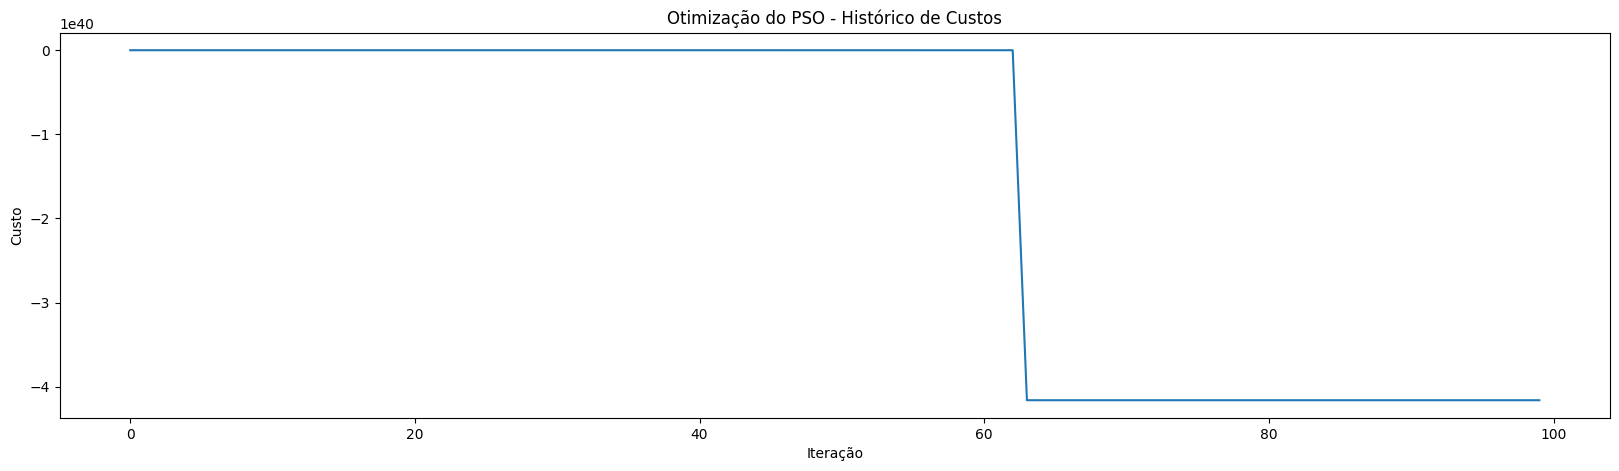

In [73]:
# Plotar gráfico de densidade da otimização
plt.figure(figsize=(20, 5))
plt.plot(cost_history)
plt.xlabel('Iteração')
plt.ylabel('Custo')
plt.title('Otimização do PSO - Histórico de Custos')
plt.show()

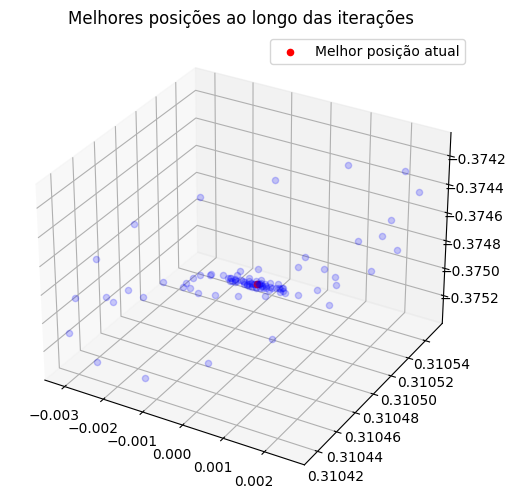

                              
*************************************************************************
Número total de iterações: 100
Número de Particulas: 100
Número de Dimensões: 3
                              
Melhor custo: -4.1620643699248976e+40
Melhor custo pessoal (pbest) de cada partícula: -2.4313519084056356e+18


In [74]:
# Plotar o gráfico 3D com todas as melhores posições
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plotar todas as melhores posições anteriores
for i in range(best_positions.shape[0]):
    ax.scatter(best_positions[i, 0], best_positions[i, 1], best_positions[i, 2], c='blue', alpha=0.2)

# Plotar a última melhor posição com uma cor diferente para destacá-la
ax.scatter(best_positions[-1, 0], best_positions[-1, 1], best_positions[-1, 2], c='red', label='Melhor posição atual')

ax.set_title('Melhores posições ao longo das iterações')
ax.legend()
plt.show()

print("                              ")
print("*************************************************************************")
print("Número total de iterações:", max_iterations)
print("Número de Particulas:", num_particles)
print("Número de Dimensões:", dimensions)
print("                              ")

print("Melhor custo:", best_cost)
print("Melhor custo pessoal (pbest) de cada partícula:", pbest_cost[0])